In [1]:
import pymongo
from pymongo import MongoClient
import pprint as pp
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import xml.etree.ElementTree as ET
import pycountry
import numpy as np
import datetime
import geopandas as gpd
import pandas as pd
from bs4 import BeautifulSoup

In [11]:
client = MongoClient()
client = MongoClient('localhost', 27017)
db = client["db1"]
print(client.list_database_names())
print(db.list_collection_names())
Posts = db["Posts"]
Users = db["Users"]
Tags = db['Tags']
Votes = db['Votes']
pp.pprint(Posts.find_one())

['Database1050', 'admin', 'config', 'db1', 'local']
['Votes', 'Posts', 'Users', 'Tags']
{'AcceptedAnswerId': '342',
 'AnswerCount': '12',
 'Body': '<p>I am about to build a piece of a project that will need to '
         "construct and post an XML document to a web service and I'd like to "
         'do it in Python, as a means to expand my skills in it.  </p>\n'
         '\n'
         '<p>Unfortunately, whilst I know the XML model fairly well in .NET, '
         "I'm uncertain what the pros and cons are of the XML models in "
         'Python.  </p>\n'
         '\n'
         '<p>Anyone have experience doing XML processing in Python? Where '
         "would you suggest I start? The XML files I'll be building will be "
         'fairly simple.</p>\n',
 'ClosedDate': '2016-03-26T01:51:47.153',
 'CommentCount': '2',
 'CreationDate': '2008-08-02T03:35:55.697',
 'FavoriteCount': '7',
 'Id': '337',
 'LastActivityDate': '2019-05-22T00:27:38.800',
 'LastEditDate': '2016-12-30T12:56:21.493',
 '

In [12]:
print("Registered Users: ", Users.count_documents({}))
print("Total Questions: ", Posts.count_documents({"PostTypeId" : '1'}))
print("Total Answers: ", Posts.count_documents({"PostTypeId" : '2'}))
print("Total: ", Posts.count_documents({}))
print("Total Votes: ", Votes.count_documents({}))

Registered Users:  670395
Total Questions:  1358860
Total Answers:  2021741
Total:  3380601
Total Votes 13516747


In [4]:
votes = {}
for post in Posts.find({"OwnerUserId" : {"$exists" : "True"}},
                       {"OwnerUserId"}):
    try:
        votes[post["OwnerUserId"]] += 1
    except:
        votes[post["OwnerUserId"]] = 2


In [5]:
post_dd = np.array([v for _, v in votes.items()])
len(post_dd)

670395

In [14]:
post_dd[::-1].sort()
print(post_dd[0])
len(post_dd)
t = 0
x = 80
for idx, i in enumerate(post_dd):
    t += i
    if t > (3380601)*(x/100):
        t = idx
        break
print(t)
ratio = t / 670395 * 100
print(f"{ratio:.2f}% of users make up {x}% of posts")

18950
135931
20.28% of users make up 80% of posts


In [16]:
i = 0
all_text = ""
for rec in Posts.find({'Body' :{ "$exists": "true"} }, 
                            {'Body'}).limit(50000):
    all_text += rec["Body"] + " "
    i += 1
print(i)
soup = BeautifulSoup(all_text)
code_text = ""
for a in soup.find_all('code'):
    code_text += a.text
for a in soup.find_all('code'):
    a.decompose()
non_code_text = soup.text
# print(non_code_text[:10000])
print(code_text[:100])

50000
forexpandNode()locate InsertFontHere
/System/Library/Fonts/Library/Fonts~/Library/FontsConvert taxes


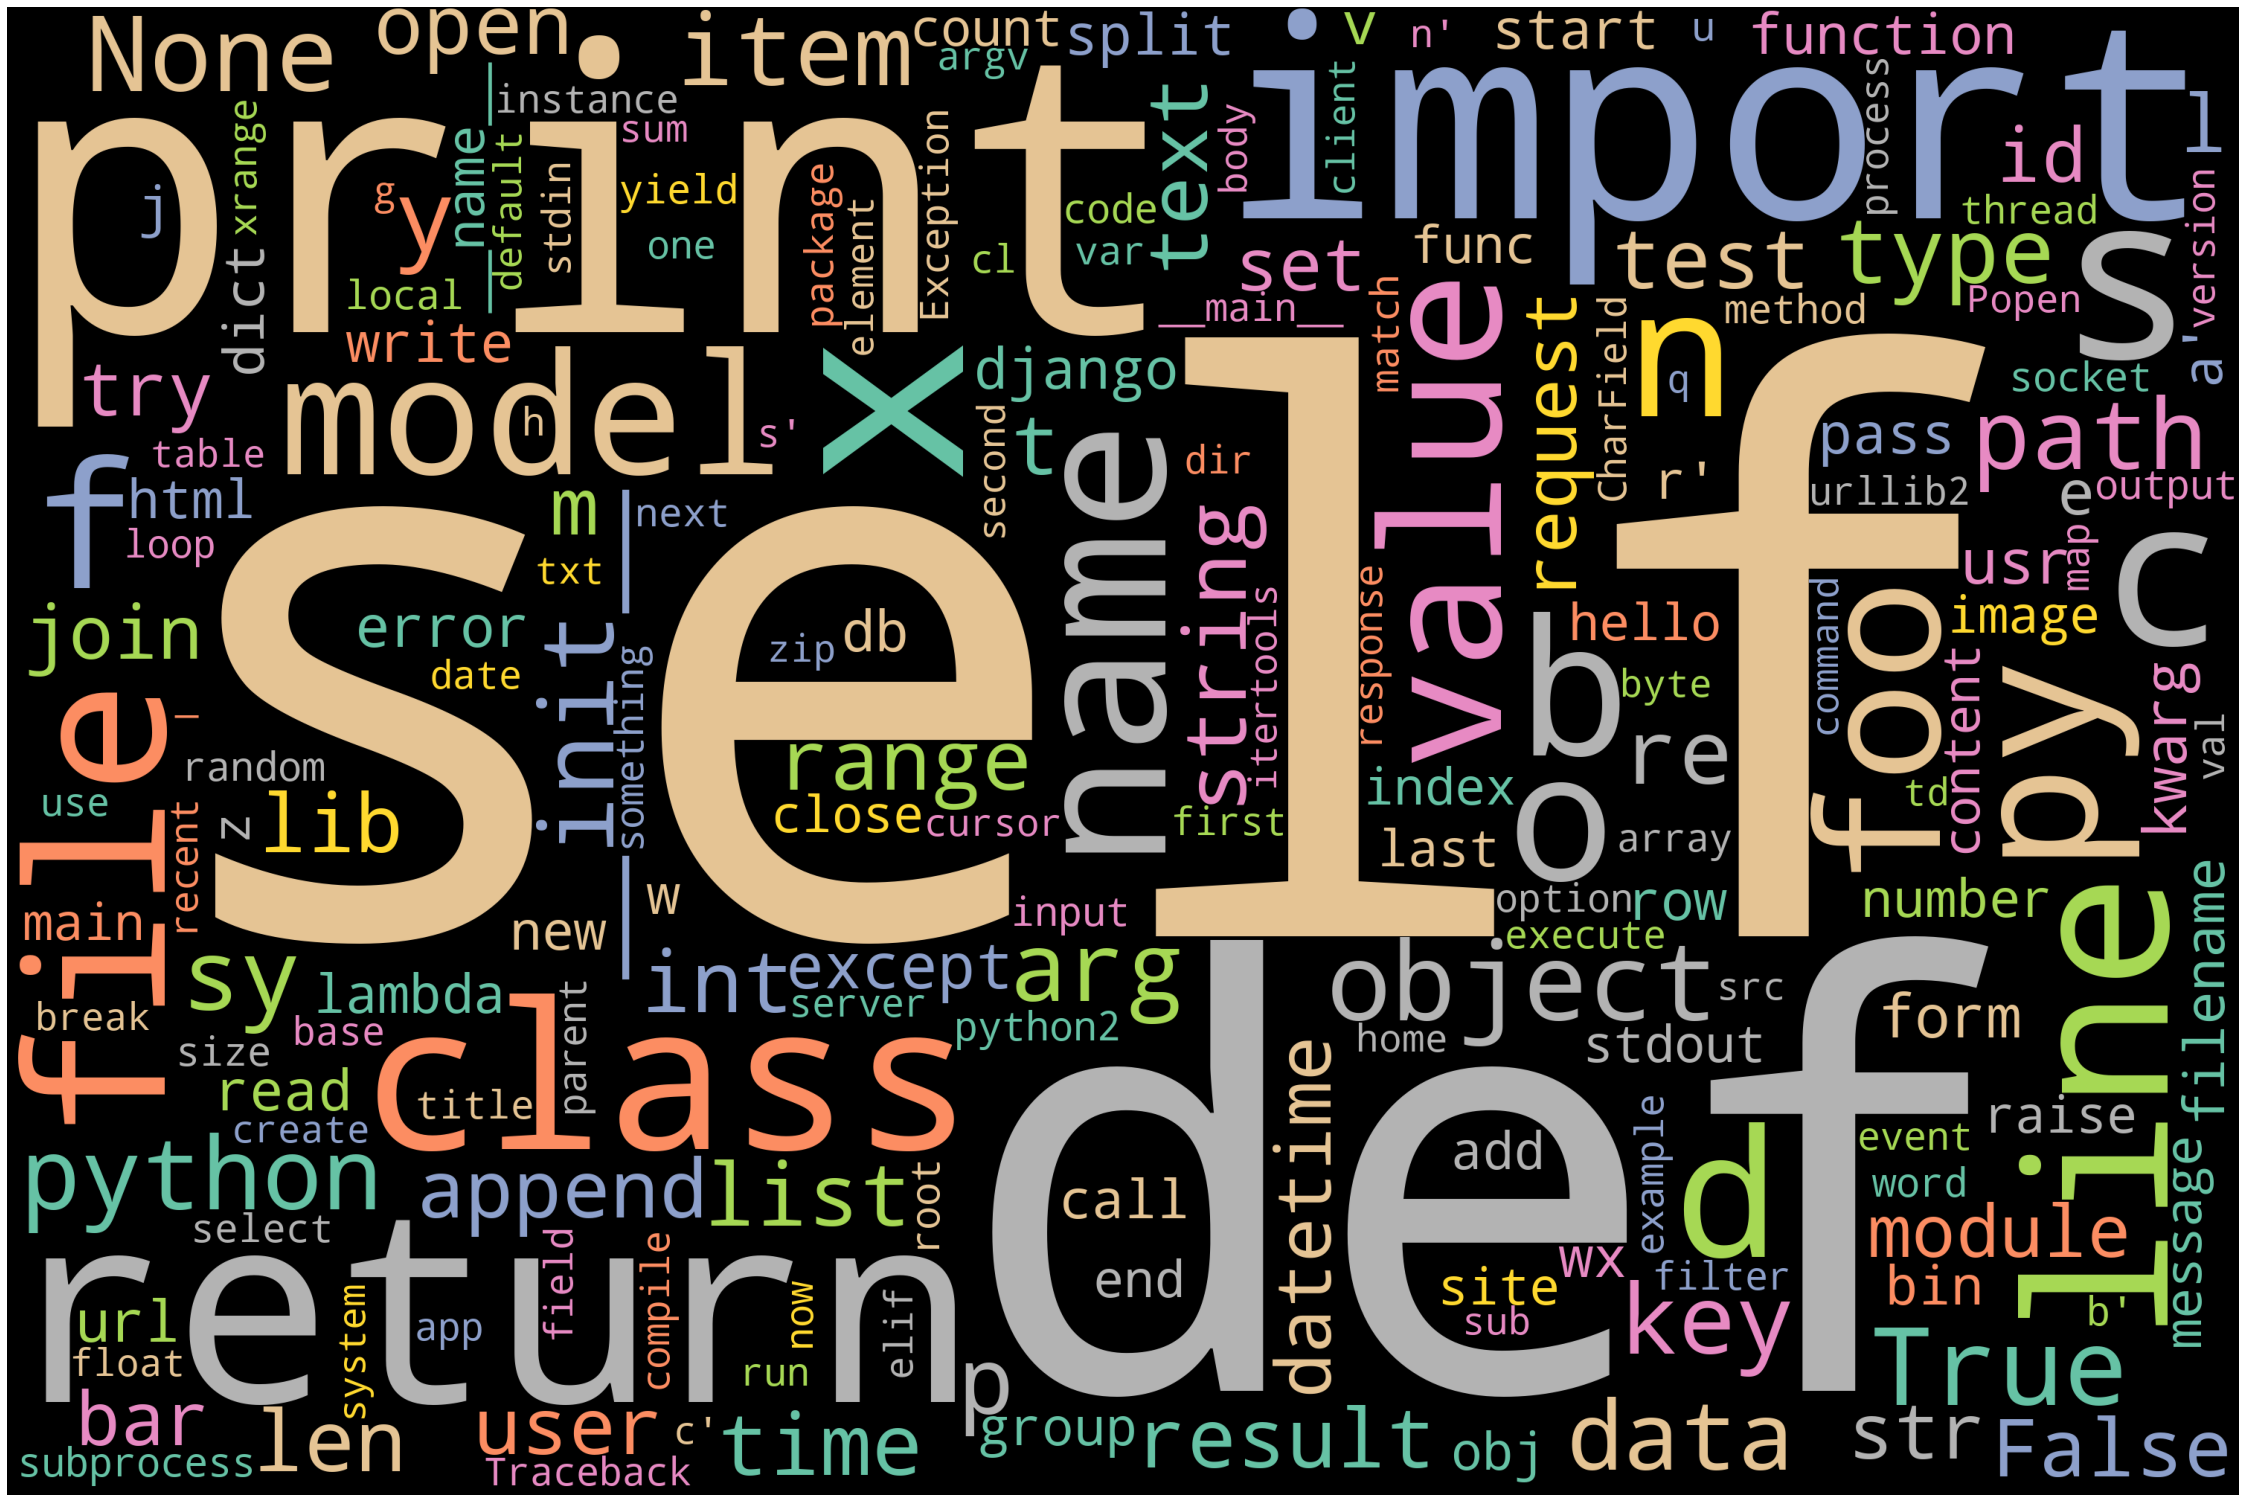

In [17]:
text = code_text
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
# text = re.sub(r'==.*?==+', '', text)
# text = re.sub(r'http\S+', '', text)
text = re.sub(r'&\S+', '', text)
# text = text.replace('\n', '')
# text = remove_tags(text)
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,
                      background_color='black', colormap='Set2',
                      collocations=False, stopwords = STOPWORDS).generate(text)

plot_cloud(wordcloud)
wordcloud.to_file("wordcloud-py.png")

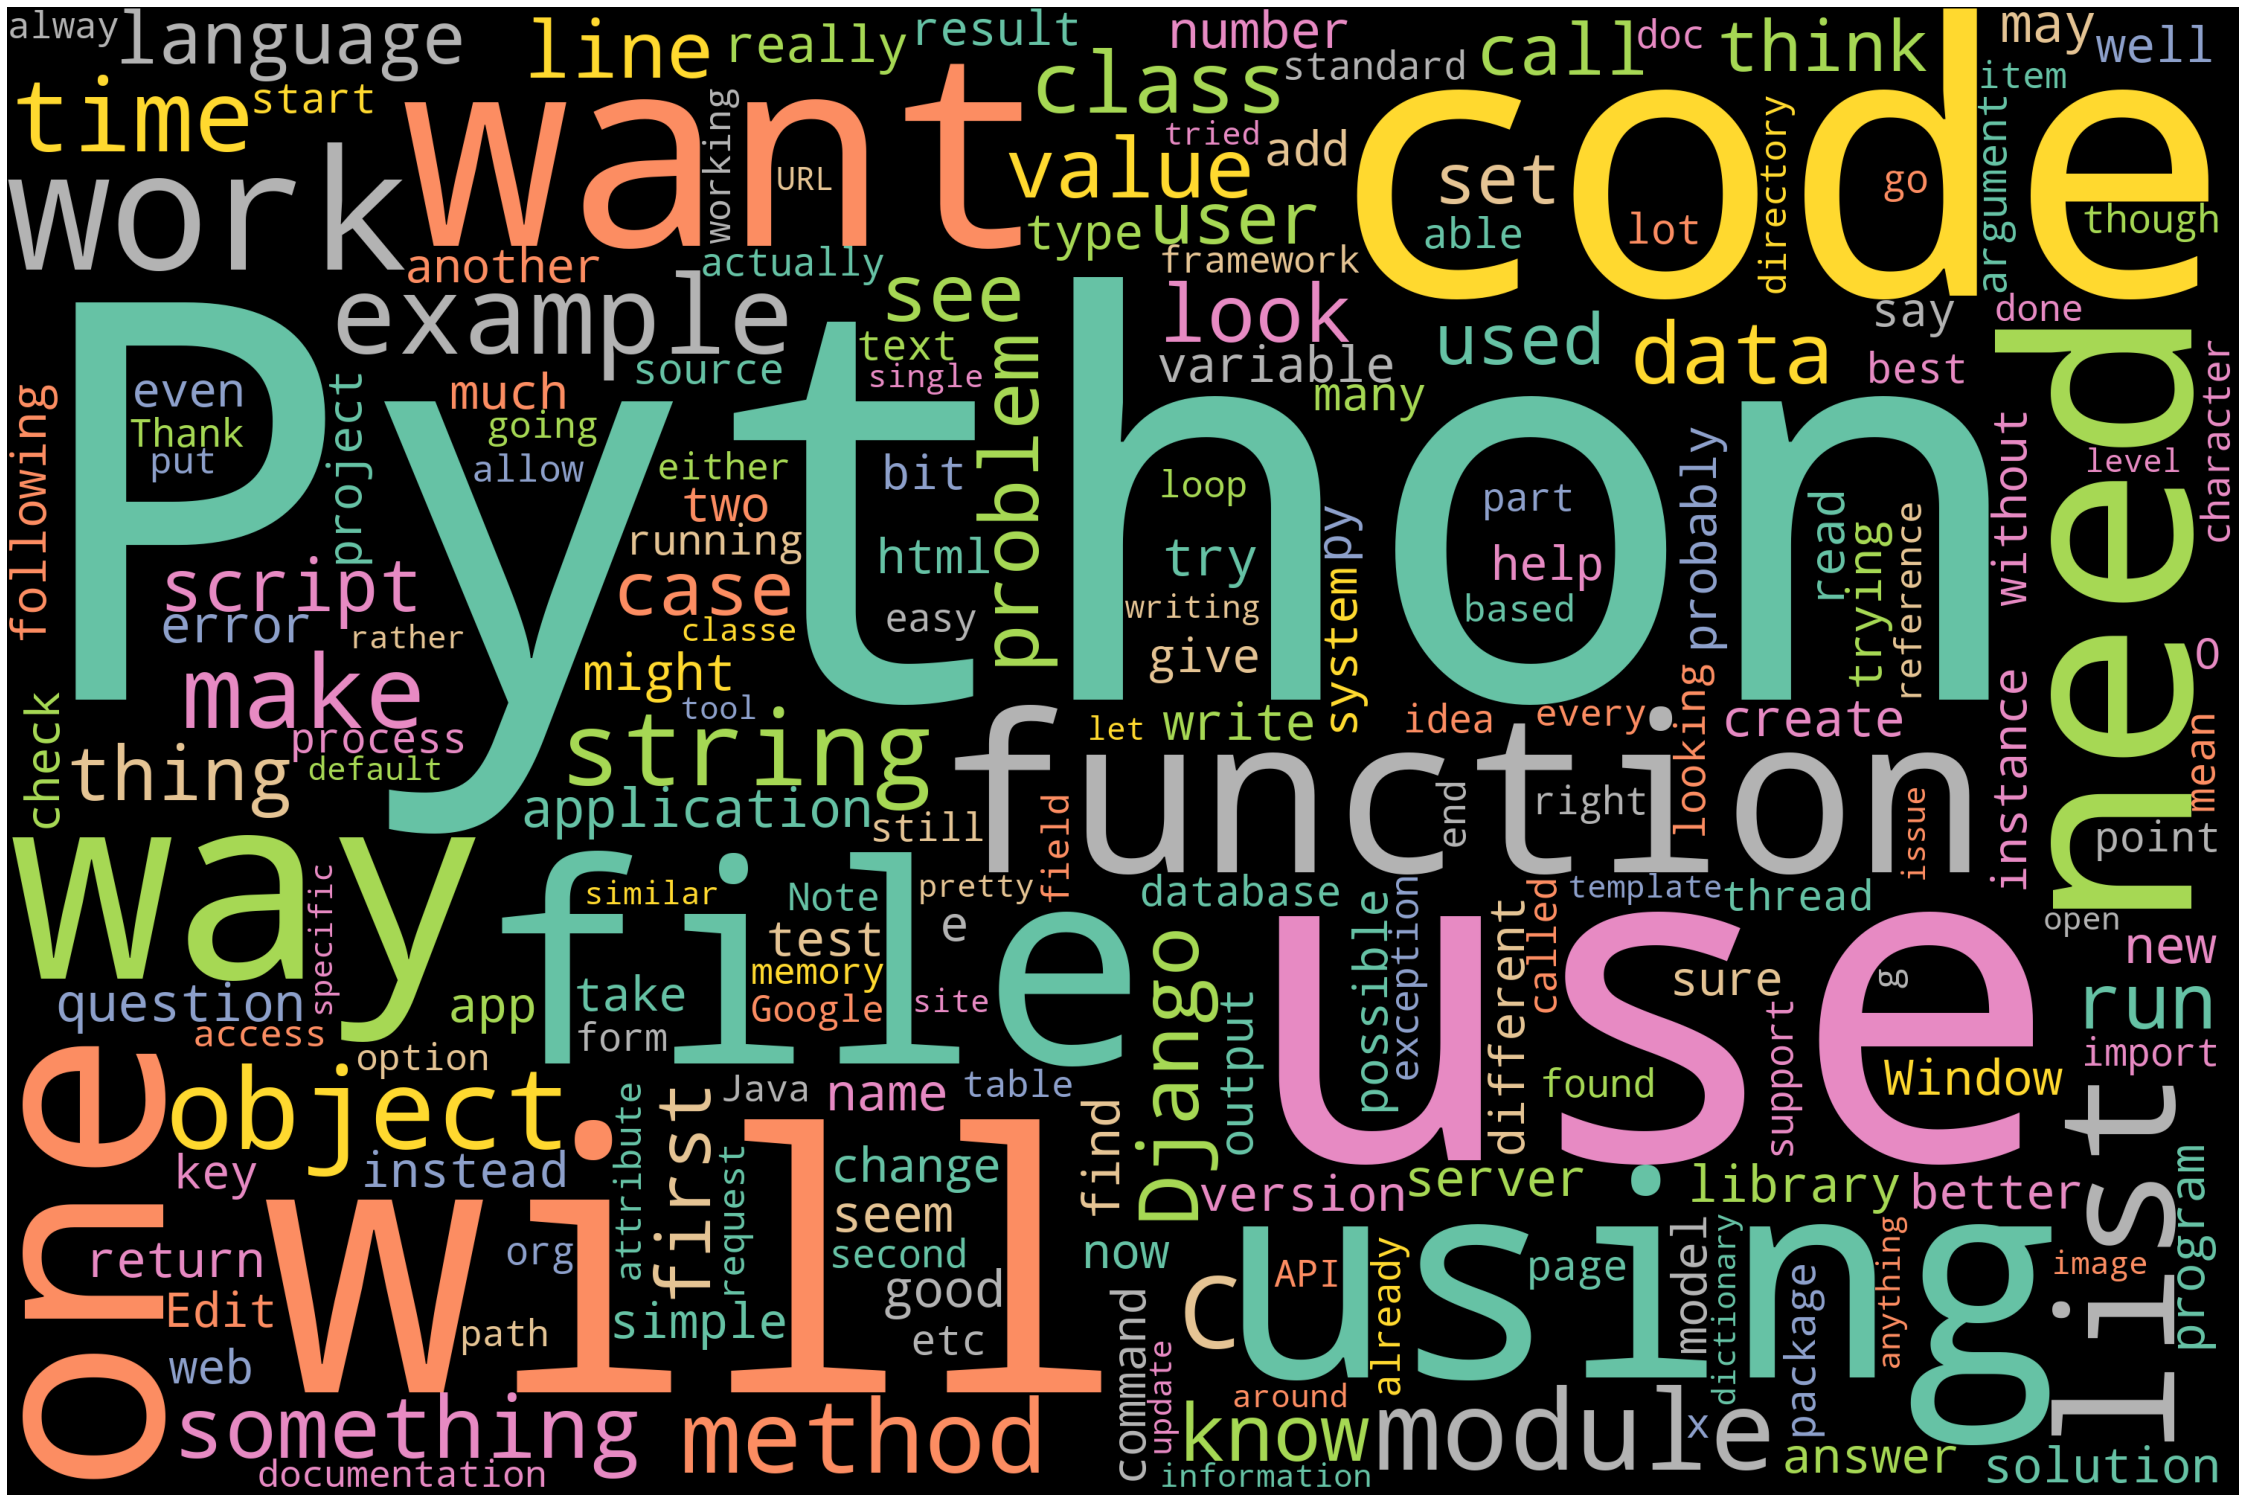

In [18]:
text = non_code_text
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
# text = re.sub(r'==.*?==+', '', text)
# text = re.sub(r'http\S+', '', text)
# text = re.sub(r'&\S+', '', text)
# text = text.replace('\n', '')
# text = remove_tags(text)
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,
                      background_color='black', colormap='Set2',
                      collocations=False, stopwords = STOPWORDS).generate(text)

plot_cloud(wordcloud)
wordcloud.to_file("wordcloud-text.png")

['python', 'python-3.x', 'pandas', 'django', 'numpy', 'python-2.7', 'list', 'matplotlib', 'dataframe', 'dictionary'] [1358860, 125609, 119220, 111953, 62820, 60590, 42883, 38246, 33927, 29821]


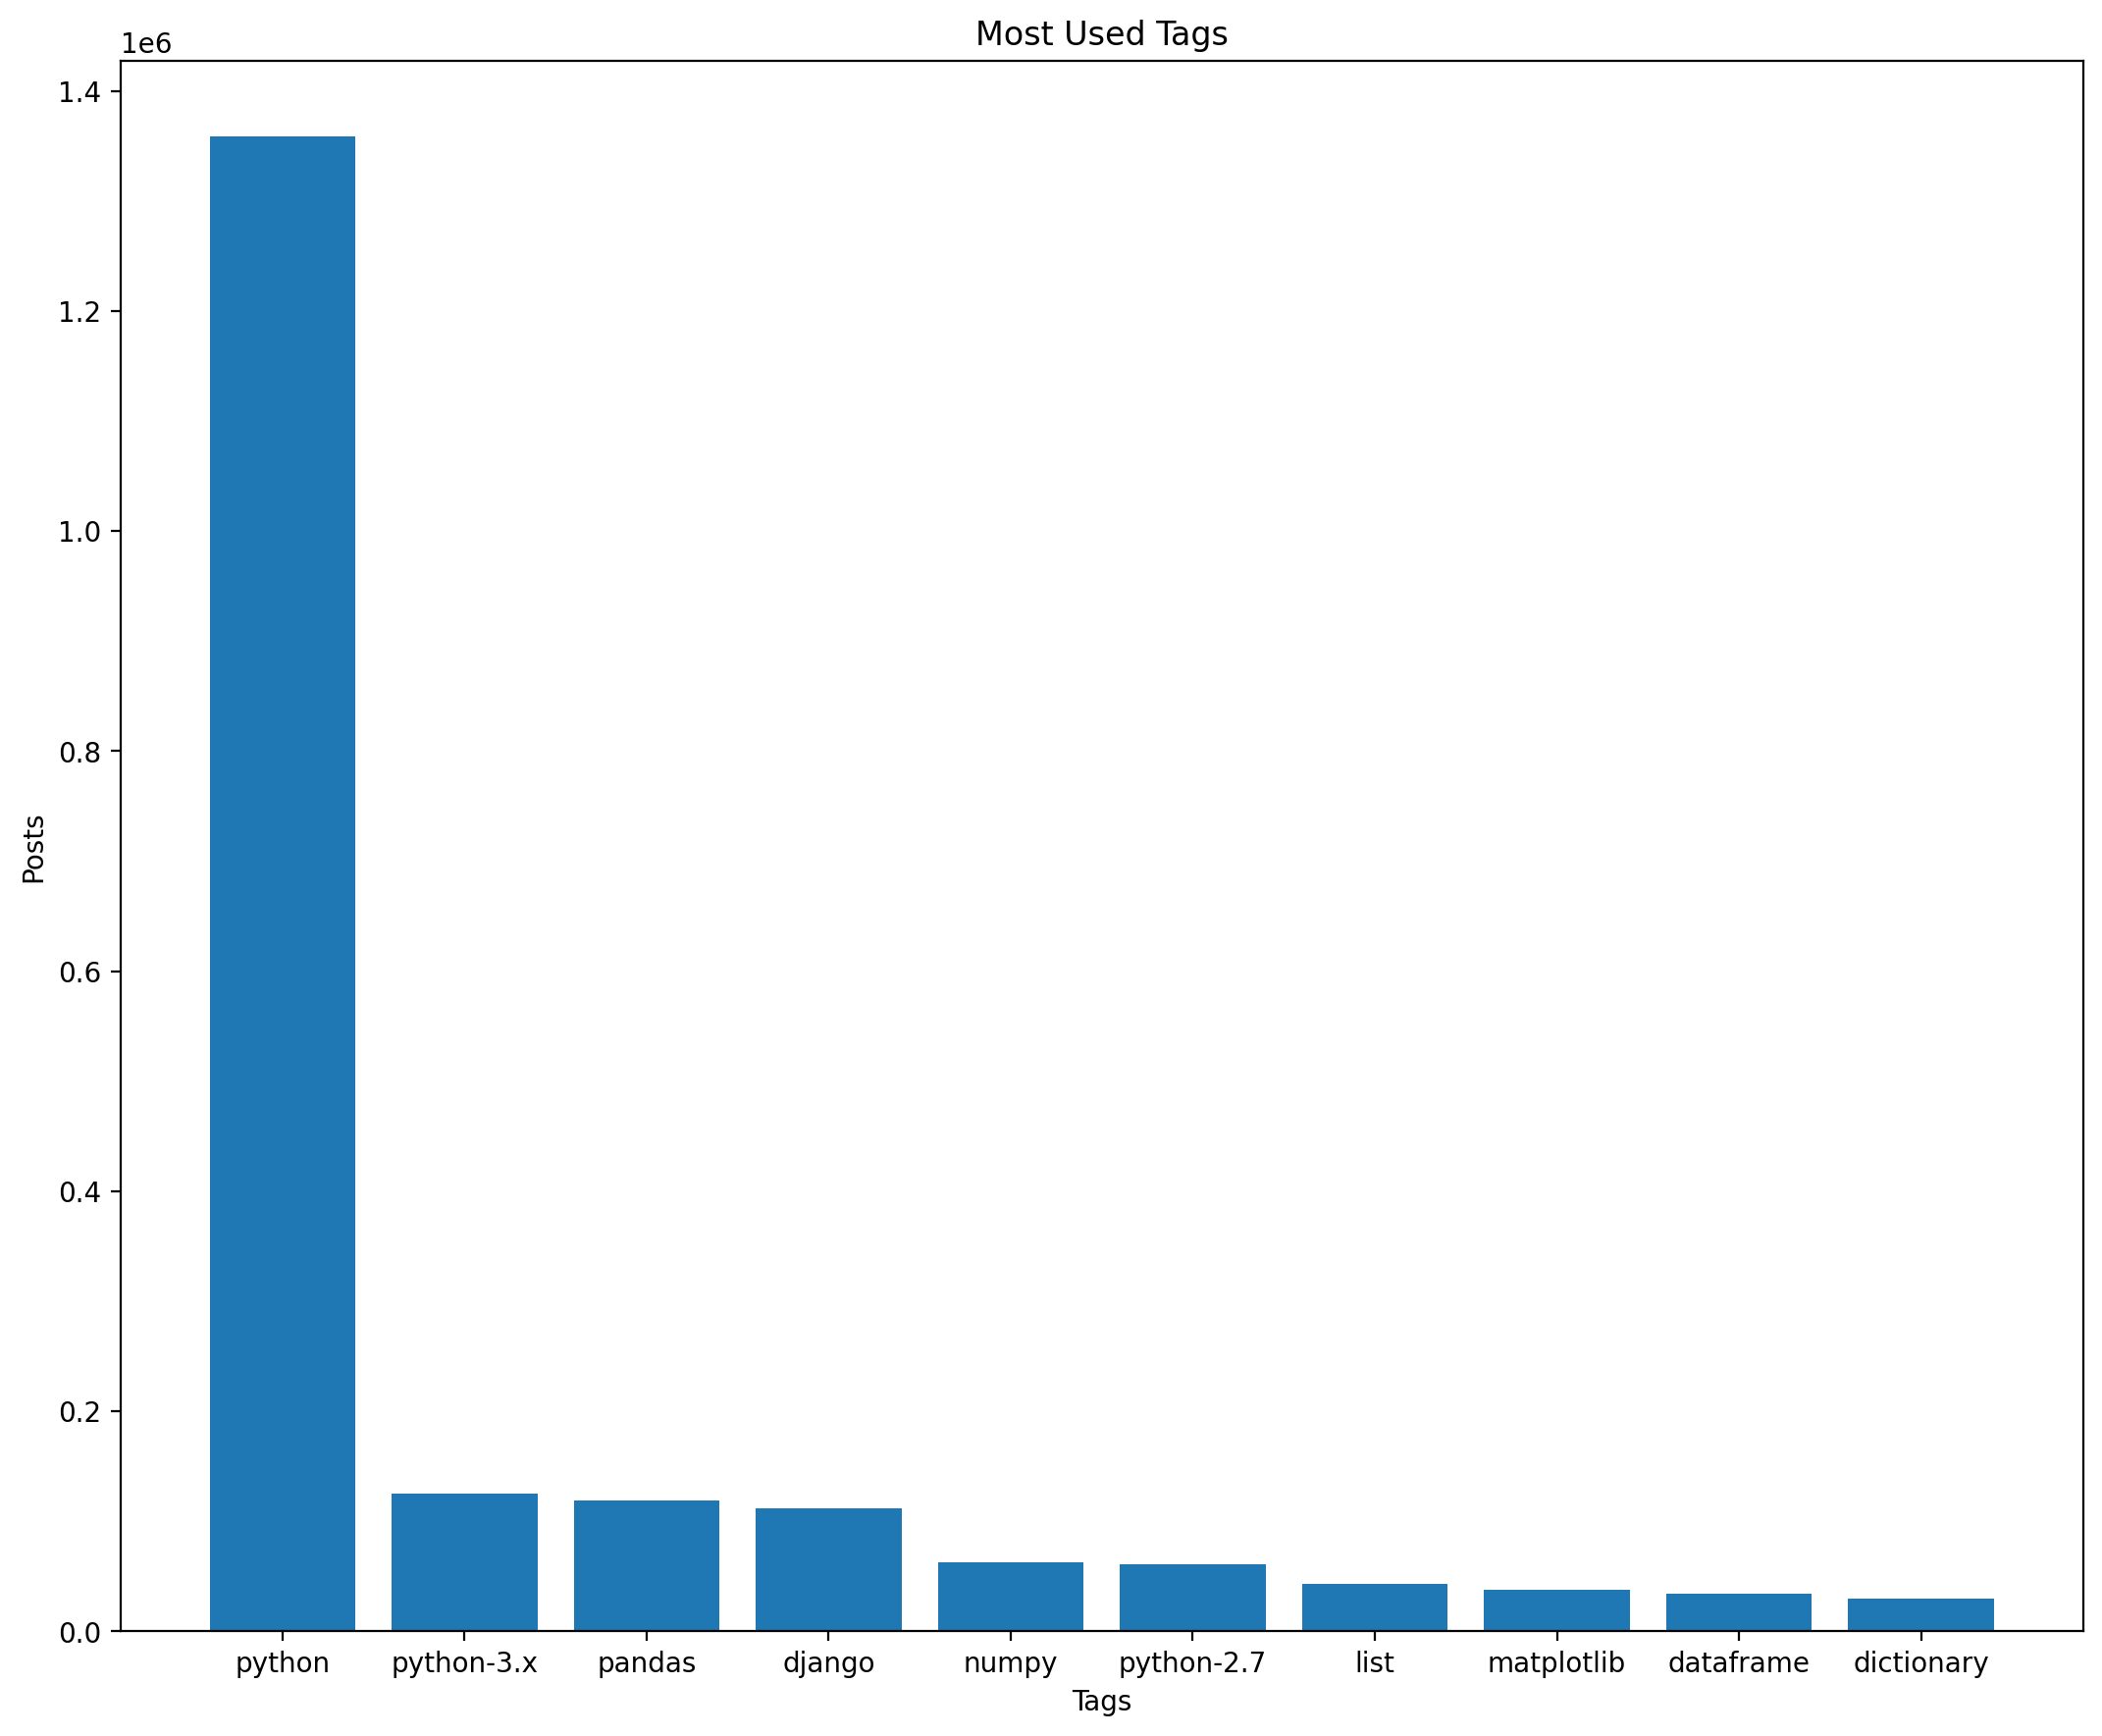

['python-3.x', 'pandas', 'django', 'numpy', 'python-2.7', 'list', 'matplotlib', 'dataframe', 'dictionary'] [125609, 119220, 111953, 62820, 60590, 42883, 38246, 33927, 29821]


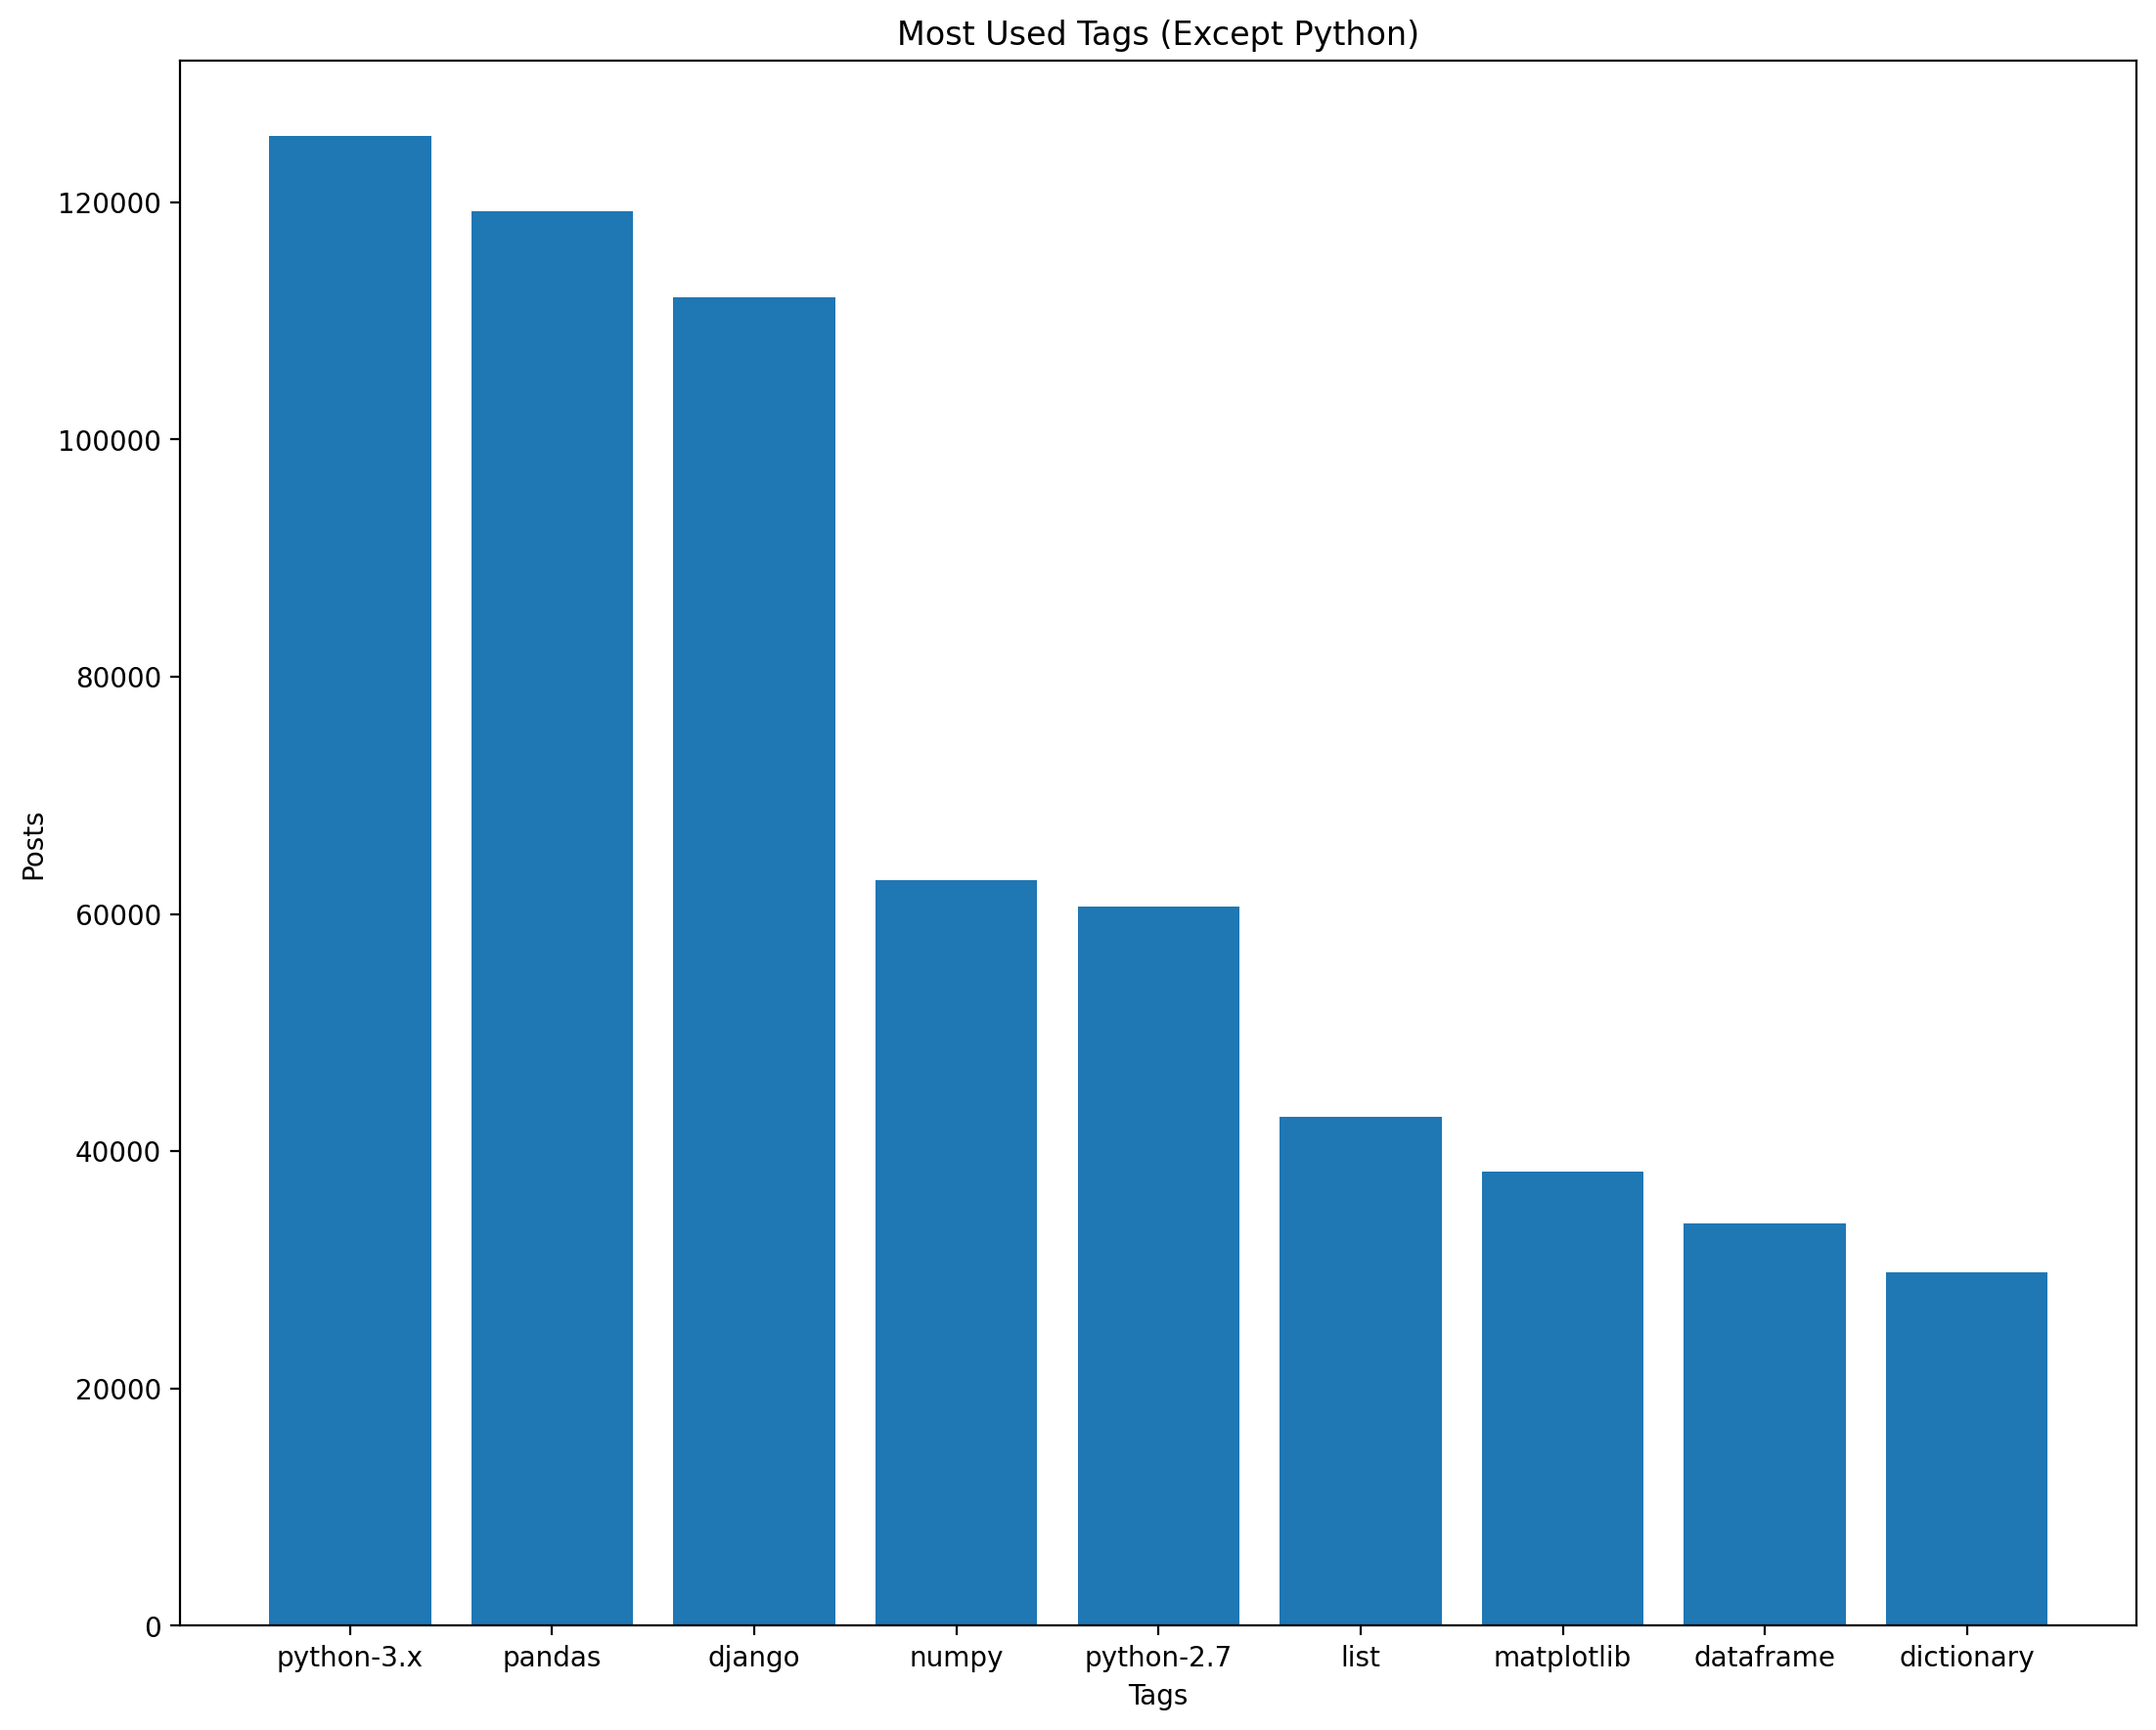

In [19]:
tags = {}
t = 0
for rec in Posts.find({"PostTypeId" : '1'},{'Tags'}):
    if "Tags" in rec:
        t += 1
        s = rec["Tags"][1:]
        s = s.replace(">","")
        for tag in s.split("<"):
            if tag not in tags:
                tags[tag] = 1
            else:
                tags[tag] += 1
# pprint.pprint(tags)
# print(t)
tag_data = []
for key in tags:
    tag_data.append([key, tags[key]])

tag_data.sort()
tag_data = sorted(tag_data, key = lambda x: -x[1])
x = [t[0] for t in tag_data[0:10]]
y = [t[1] for t in tag_data[0:10]]
print(x, y)
fig = plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
ax.set_xlabel("Tags")
ax.set_ylabel("Posts")
ax.set_title("Most Used Tags")
plt.savefig('Most_used_tags.png', bbox_inches = 'tight')
plt.show()
x = [t[0] for t in tag_data[1:10]]
y = [t[1] for t in tag_data[1:10]]
print(x, y)
fig = plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
ax.set_xlabel("Tags")
ax.set_ylabel("Posts")
ax.set_title("Most Used Tags (Except Python)")
plt.savefig('Most_used_tags_noPy.png', bbox_inches = 'tight')
plt.show()

In [32]:
dates = []
mydate = datetime.datetime.strptime("2008-07-01", "%Y-%m-%d")
for i in range(145):
    dates.append(mydate)
    next_month = datetime.datetime(mydate.year + (mydate.month // 12), ((mydate.month % 12) + 1), 1)
    mydate = next_month

posts = []
for post in Posts.find({"PostTypeId" : '1'},
                       {'Tags', 'CreationDate', 'Id'}):
    posts.append(post)

posts.sort(key=lambda x: int(x['Id']))



In [33]:
idx = 0
version_date = {}
version_date[0] = [0, 0, 0]
for post in posts:
    u_date = datetime.datetime.strptime(post["CreationDate"][0:10]
                                        , "%Y-%m-%d")
    while(u_date > dates[idx]):
        idx += 1
        version_date[idx] = version_date[idx - 1].copy()
    if "python-3.x" in post["Tags"]:
        version_date[idx][1] += 1
    if "python-2.7" in post["Tags"]:
        version_date[idx][0] += 1 
    if "python" in post["Tags"]:
        version_date[idx][2] += 1    


In [30]:
print(version_date)

{0: [0, 0, 0], 1: [0, 0, 0], 2: [0, 1, 133], 3: [3, 3, 693], 4: [3, 12, 1184], 5: [3, 13, 1646], 6: [3, 24, 2089], 7: [3, 29, 2723], 8: [3, 38, 3352], 9: [3, 42, 4132], 10: [4, 50, 4895], 11: [6, 66, 5901], 12: [6, 75, 6944], 13: [6, 87, 8092], 14: [6, 102, 9247], 15: [6, 116, 10424], 16: [6, 140, 11825], 17: [7, 154, 13427], 18: [7, 169, 14979], 19: [8, 181, 16970], 20: [8, 203, 18846], 21: [8, 239, 20896], 22: [10, 256, 22694], 23: [11, 282, 24742], 24: [13, 304, 26974], 25: [16, 328, 29520], 26: [19, 362, 32061], 27: [23, 391, 34304], 28: [29, 421, 36973], 29: [34, 462, 39610], 30: [38, 490, 42041], 31: [45, 544, 45021], 32: [54, 593, 48073], 33: [57, 656, 51787], 34: [64, 696, 55134], 35: [82, 745, 58714], 36: [97, 800, 62150], 37: [114, 855, 65822], 38: [130, 934, 69669], 39: [154, 1007, 73150], 40: [175, 1061, 76833], 41: [208, 1148, 80742], 42: [235, 1223, 84257], 43: [274, 1320, 88588], 44: [362, 1421, 93113], 45: [460, 1517, 98090], 46: [567, 1633, 103085], 47: [686, 1752, 108

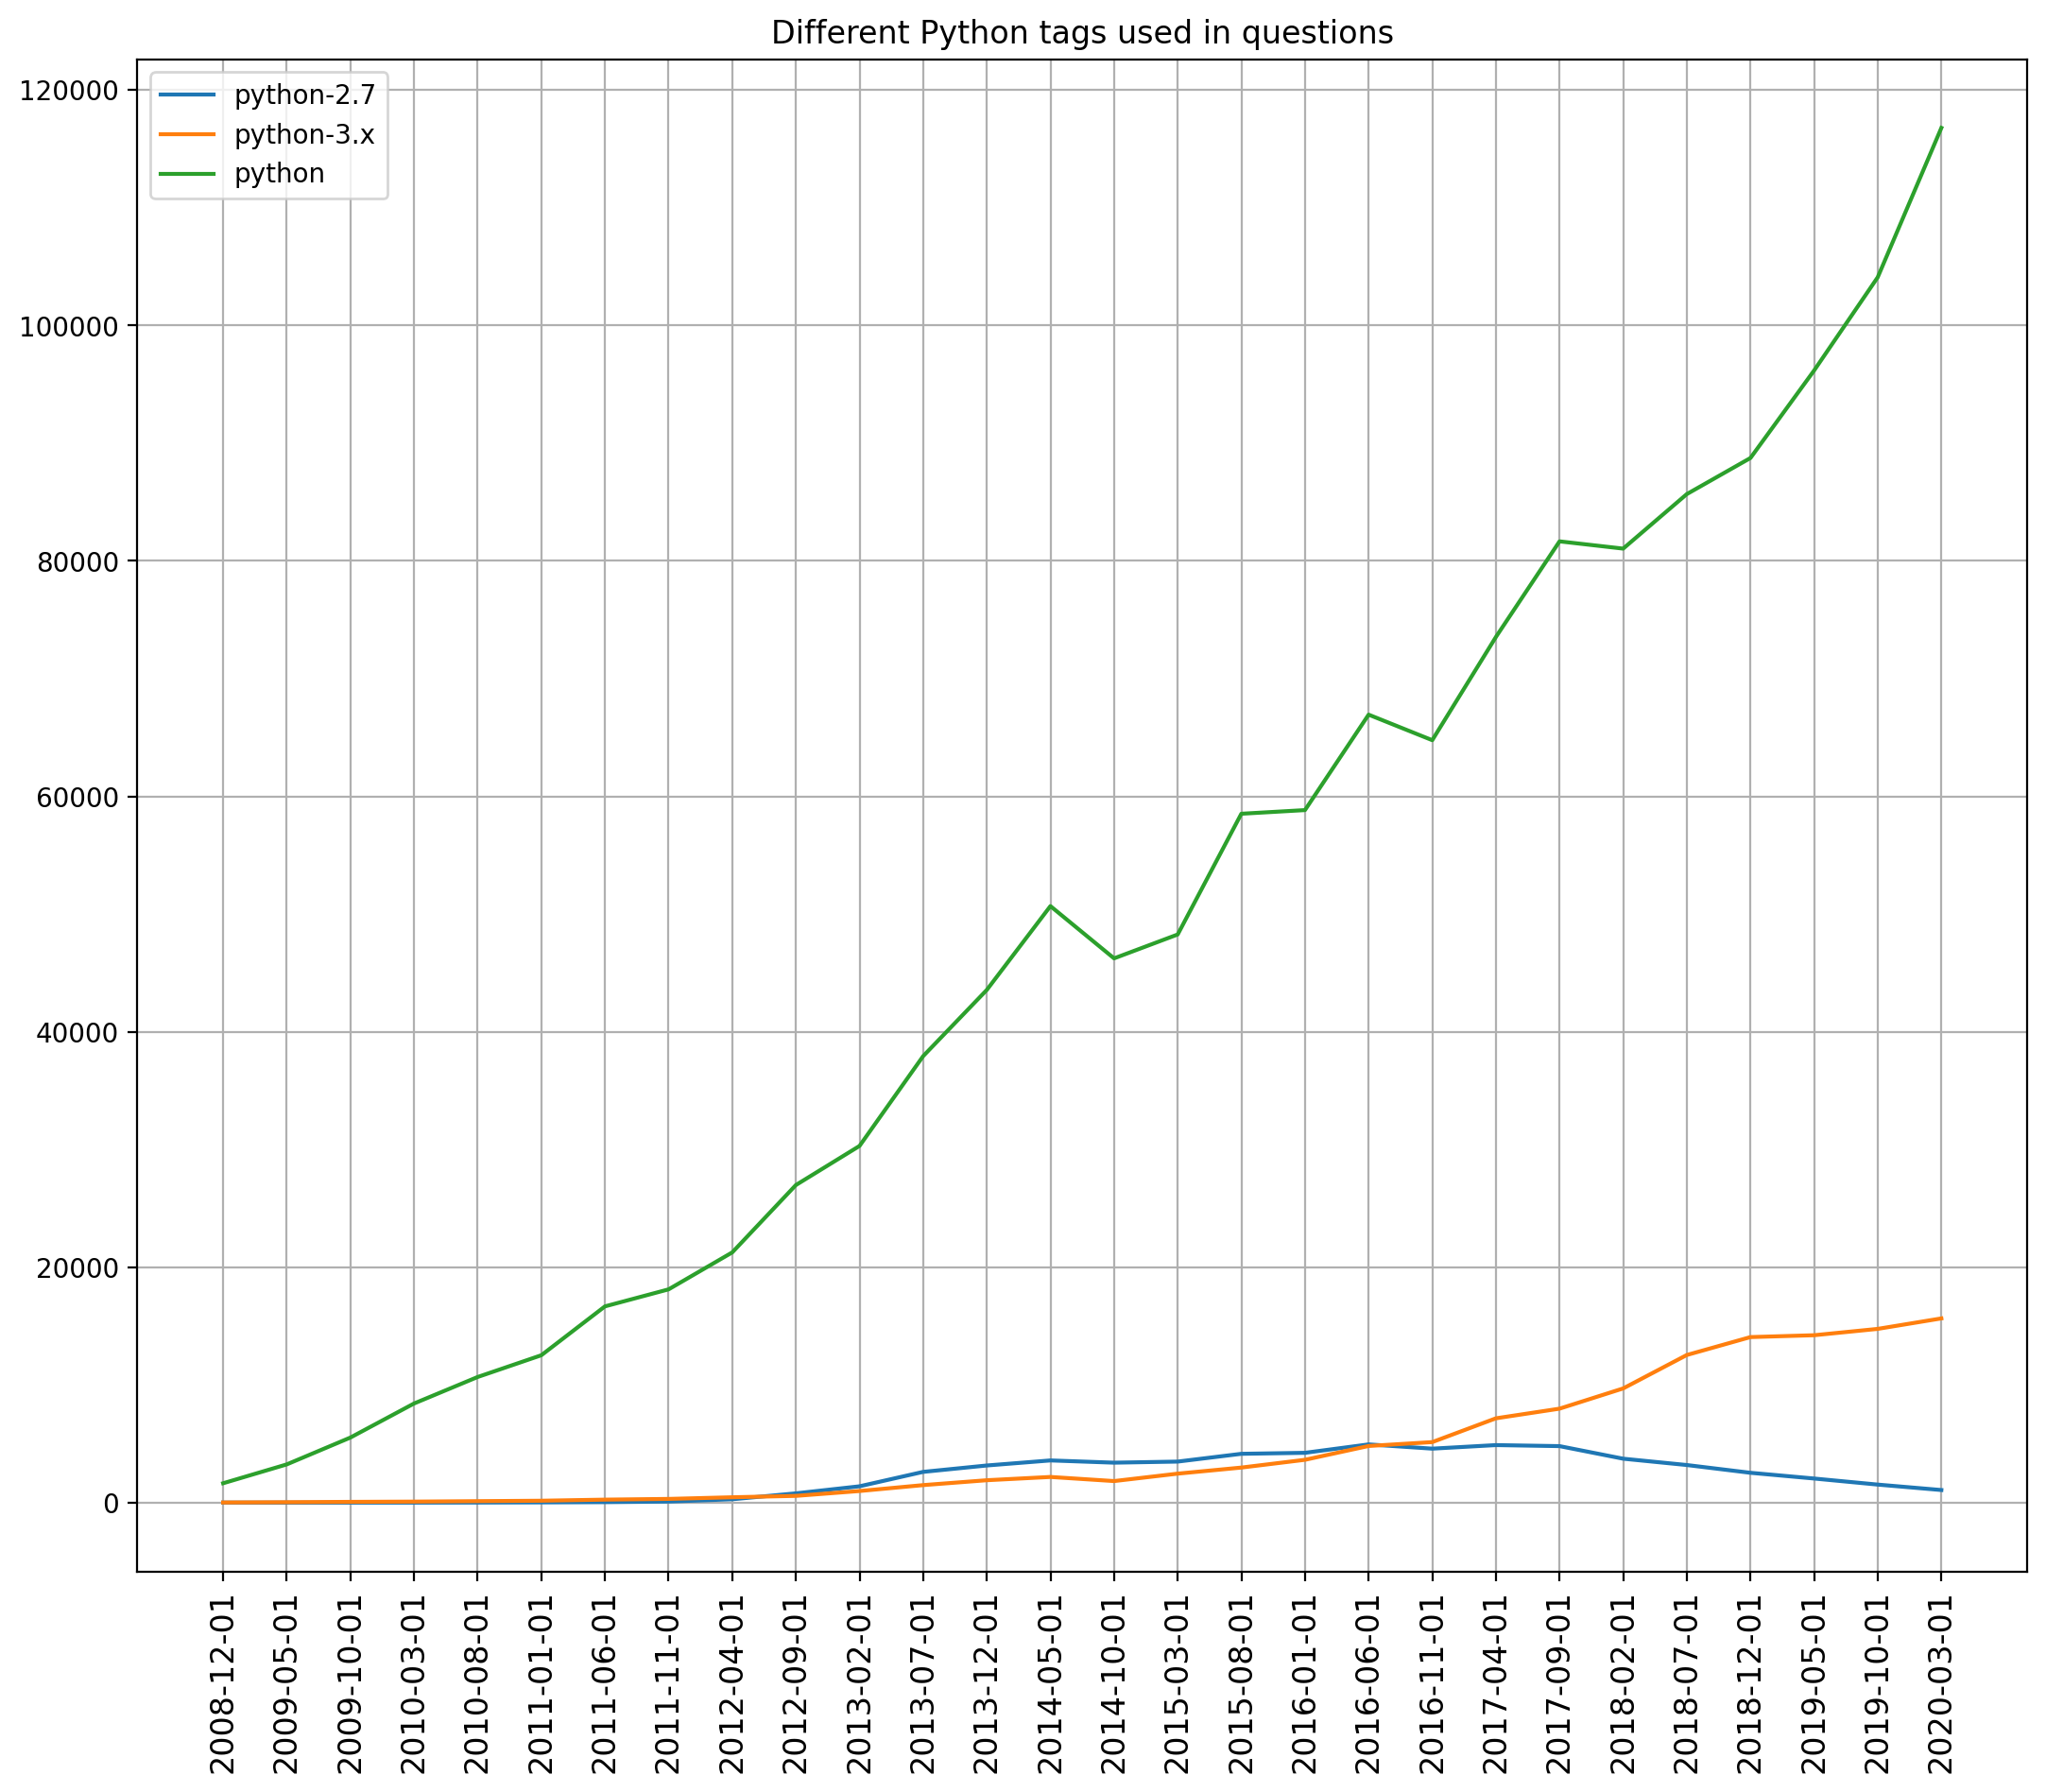

In [34]:
tags = ["python-2.7", "python-3.x", "python"]
skip_label = 5
x = np.arange(skip_label, len(dates), skip_label)
x_ticks_labels = [str(dates[i])[0:10] for i in x]
fig = plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
for j in range(0, 3):
    ax.plot(x, [version_date[i][j] - version_date[i - skip_label][j] for i in x])
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=12)
ax.set_title("Different Python tags used in questions")
ax.legend(tags[0:3])
plt.grid()
plt.savefig("Python-posts-overtime.png")
plt.show()

In [10]:
# Post type Id = 1 => Actual post
# Post type Id = 2 => Answers to the post

# Every post of type1 has "Python" Tag
# Every post of type2 is an answer to a post of type1 which has python ig

In [123]:
## Explore Users
users = db["Users"]
pprint.pprint(users.find_one())
max_repo = 0
locations = ""
for user in users.find({}, {"Reputation", "Location"}):
    max_repo = max(int(user["Reputation"]), max_repo)
    if "Location" in user:
        locations += user["Location"].replace(',', '') + " "
print(max_repo)

{'AboutMe': '<p><a '
            'href="http://www.codinghorror.com/blog/archives/001169.html" '
            'rel="nofollow">Stack Overflow Valued Associate #00001</a></p>\n'
            '\n'
            '<p>Wondering how our software development process works? <a '
            'href="http://www.youtube.com/watch?v=08xQLGWTSag" '
            'rel="nofollow">Take a look!</a></p>\n'
            '\n'
            '<p>Find me <a href="http://twitter.com/codinghorror" '
            'rel="nofollow">on twitter</a>, or <a '
            'href="http://www.codinghorror.com/blog" rel="nofollow">read my '
            "blog</a>. Don't say I didn't warn you <em>because I totally "
            'did</em>.</p>\n'
            '\n'
            '<p>However, <a '
            'href="http://www.codinghorror.com/blog/2012/02/farewell-stack-exchange.html" '
            'rel="nofollow">I no longer work at Stack Exchange, Inc</a>. I\'ll '
            'miss you all. Well, <em>some</em> of you, anyway. :)</p>\n',
 '

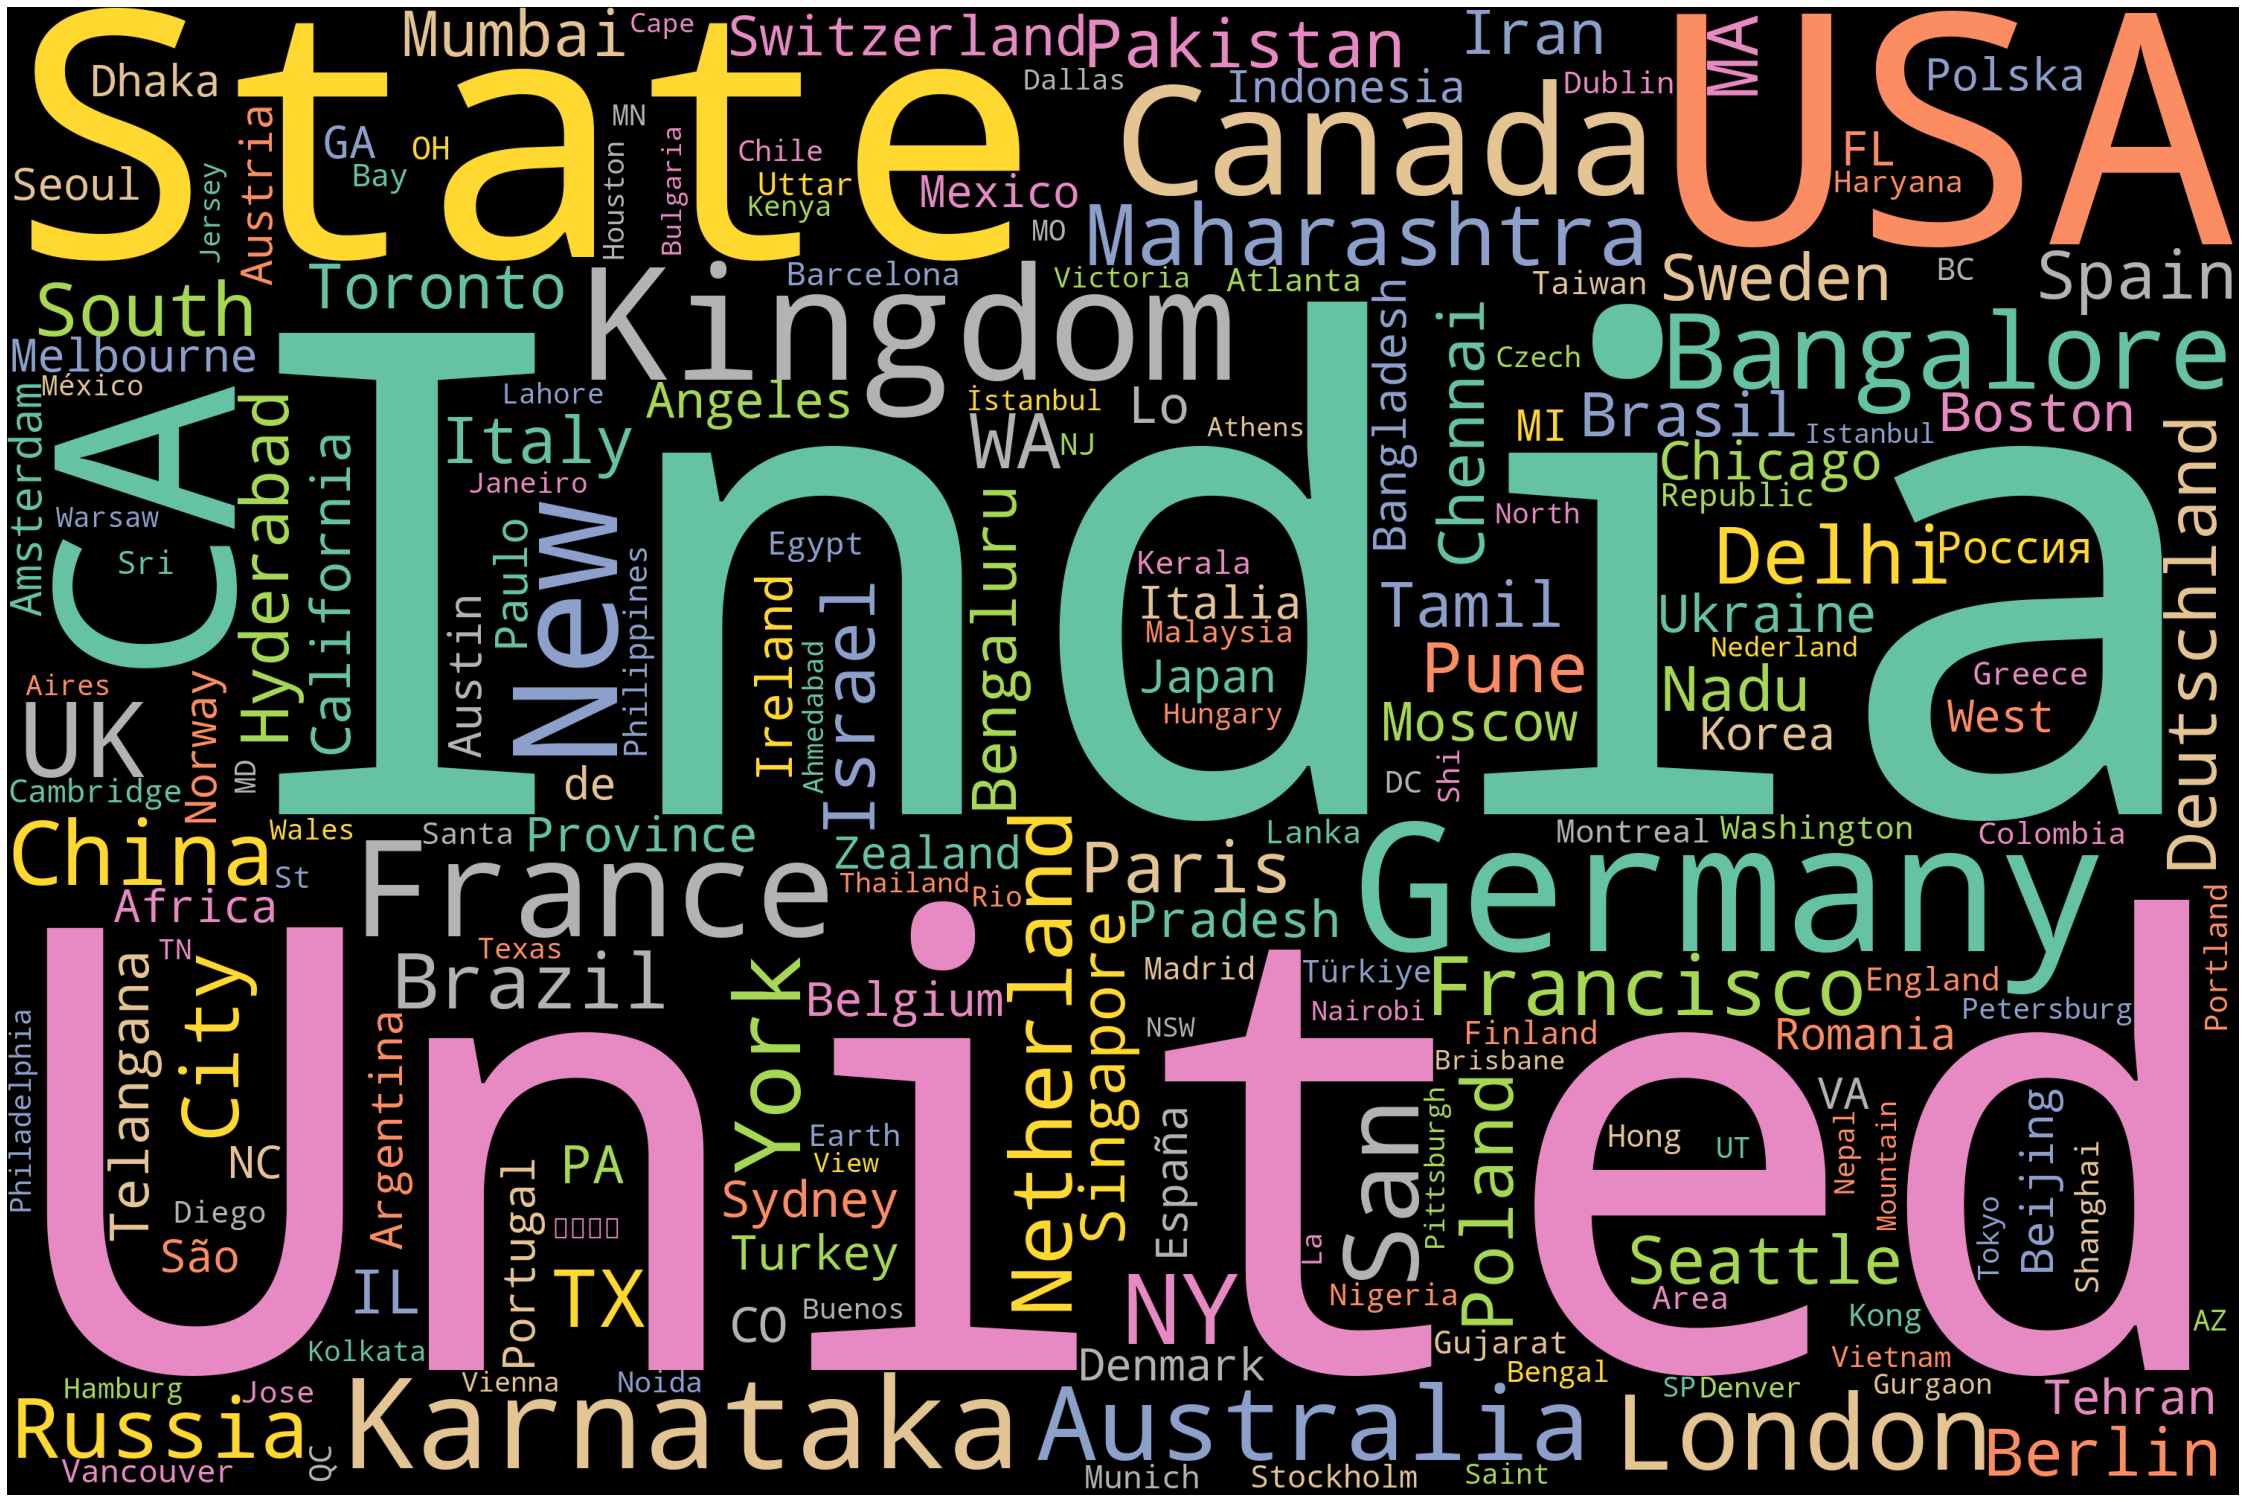

In [124]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,
                      background_color='black', colormap='Set2',
                      collocations=False, stopwords = STOPWORDS).generate(locations)

plot_cloud(wordcloud)
wordcloud.to_file("location-wordcloud.png")

In [71]:
user_country = {}
for country in pycountry.countries:
    user_country[country.name] = []

## Weird actual names
user_country["Russia"] = []
user_country["South Korea"] = []
user_country["Czech Republic"] = []
user_country["Taiwan"] = []
user_country["Iran"] = []

# US people dont give country name for some reason
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "USA", 
          "Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California",
          "Colorado", "Connecticut", "District ", "of Columbia", "Delaware", "Florida", 
          "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", 
          "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", 
          "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", 
          "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", 
          "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", 
          "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", 
          "Wisconsin", "West Virginia", "Wyoming", "San Francisco"]
            
# states = ["USA"]
c = 0
t = 0
random = ""
for user in Users.find({'Location':{"$exists" : "true"}},
                       {"Location", "Reputation", "CreationDate"}):
    found = False
    text = user["Location"].replace(',', '').strip()
    if text == '':
        continue
    t += 1
    for k in user_country:
        if k in text:
            user_country[k].append(user)
            found = True
            break
    if not found:
        for st in states:
            if st in user["Location"]:
                user_country["United States"].append(user)
                found = True
                break
    if not found:
        if "Россия" in text:
            user_country["Russia"].append(user)
            found = True
        elif "Italia" in text:
            user_country["Italy"].append(user)
            found = True
        elif "Polska" in text:
            user_country["Poland"].append(user)
            found = True
        elif "South Korea" in text or "Seoul" in text:
            user_country["South Korea"].append(user)
            found = True
        elif "Tehran" in text:
            user_country["Iran"].append(user)
            found = True
        elif "Brasil" in text:
            user_country["Brazil"].append(user)
            found = True
        elif "Deutschland" in text:
            user_country["Germany"].append(user)
            found = True
        elif "UK" in text or "London" in text:
            user_country["United Kingdom"].append(user)
            found = True
        elif "Espa" in text:
            user_country["Spain"].append(user)
            found = True 
        else:
            random += text + " "
            c += 1
print(c, t, 1 - c/t)

28332 262141 0.8919207602015709


In [69]:
country_count = {}
for country in user_country:
    if country not in country_count:
        country_count[country] = 1
    country_count[country] += len(user_country[country])

['United States', 'India', 'United Kingdom', 'Germany', 'Canada', 'France', 'Australia', 'Brazil', 'Russia', 'China'] [42594, 33316, 16049, 12550, 8848, 6929, 5393, 5073, 4720, 4158]


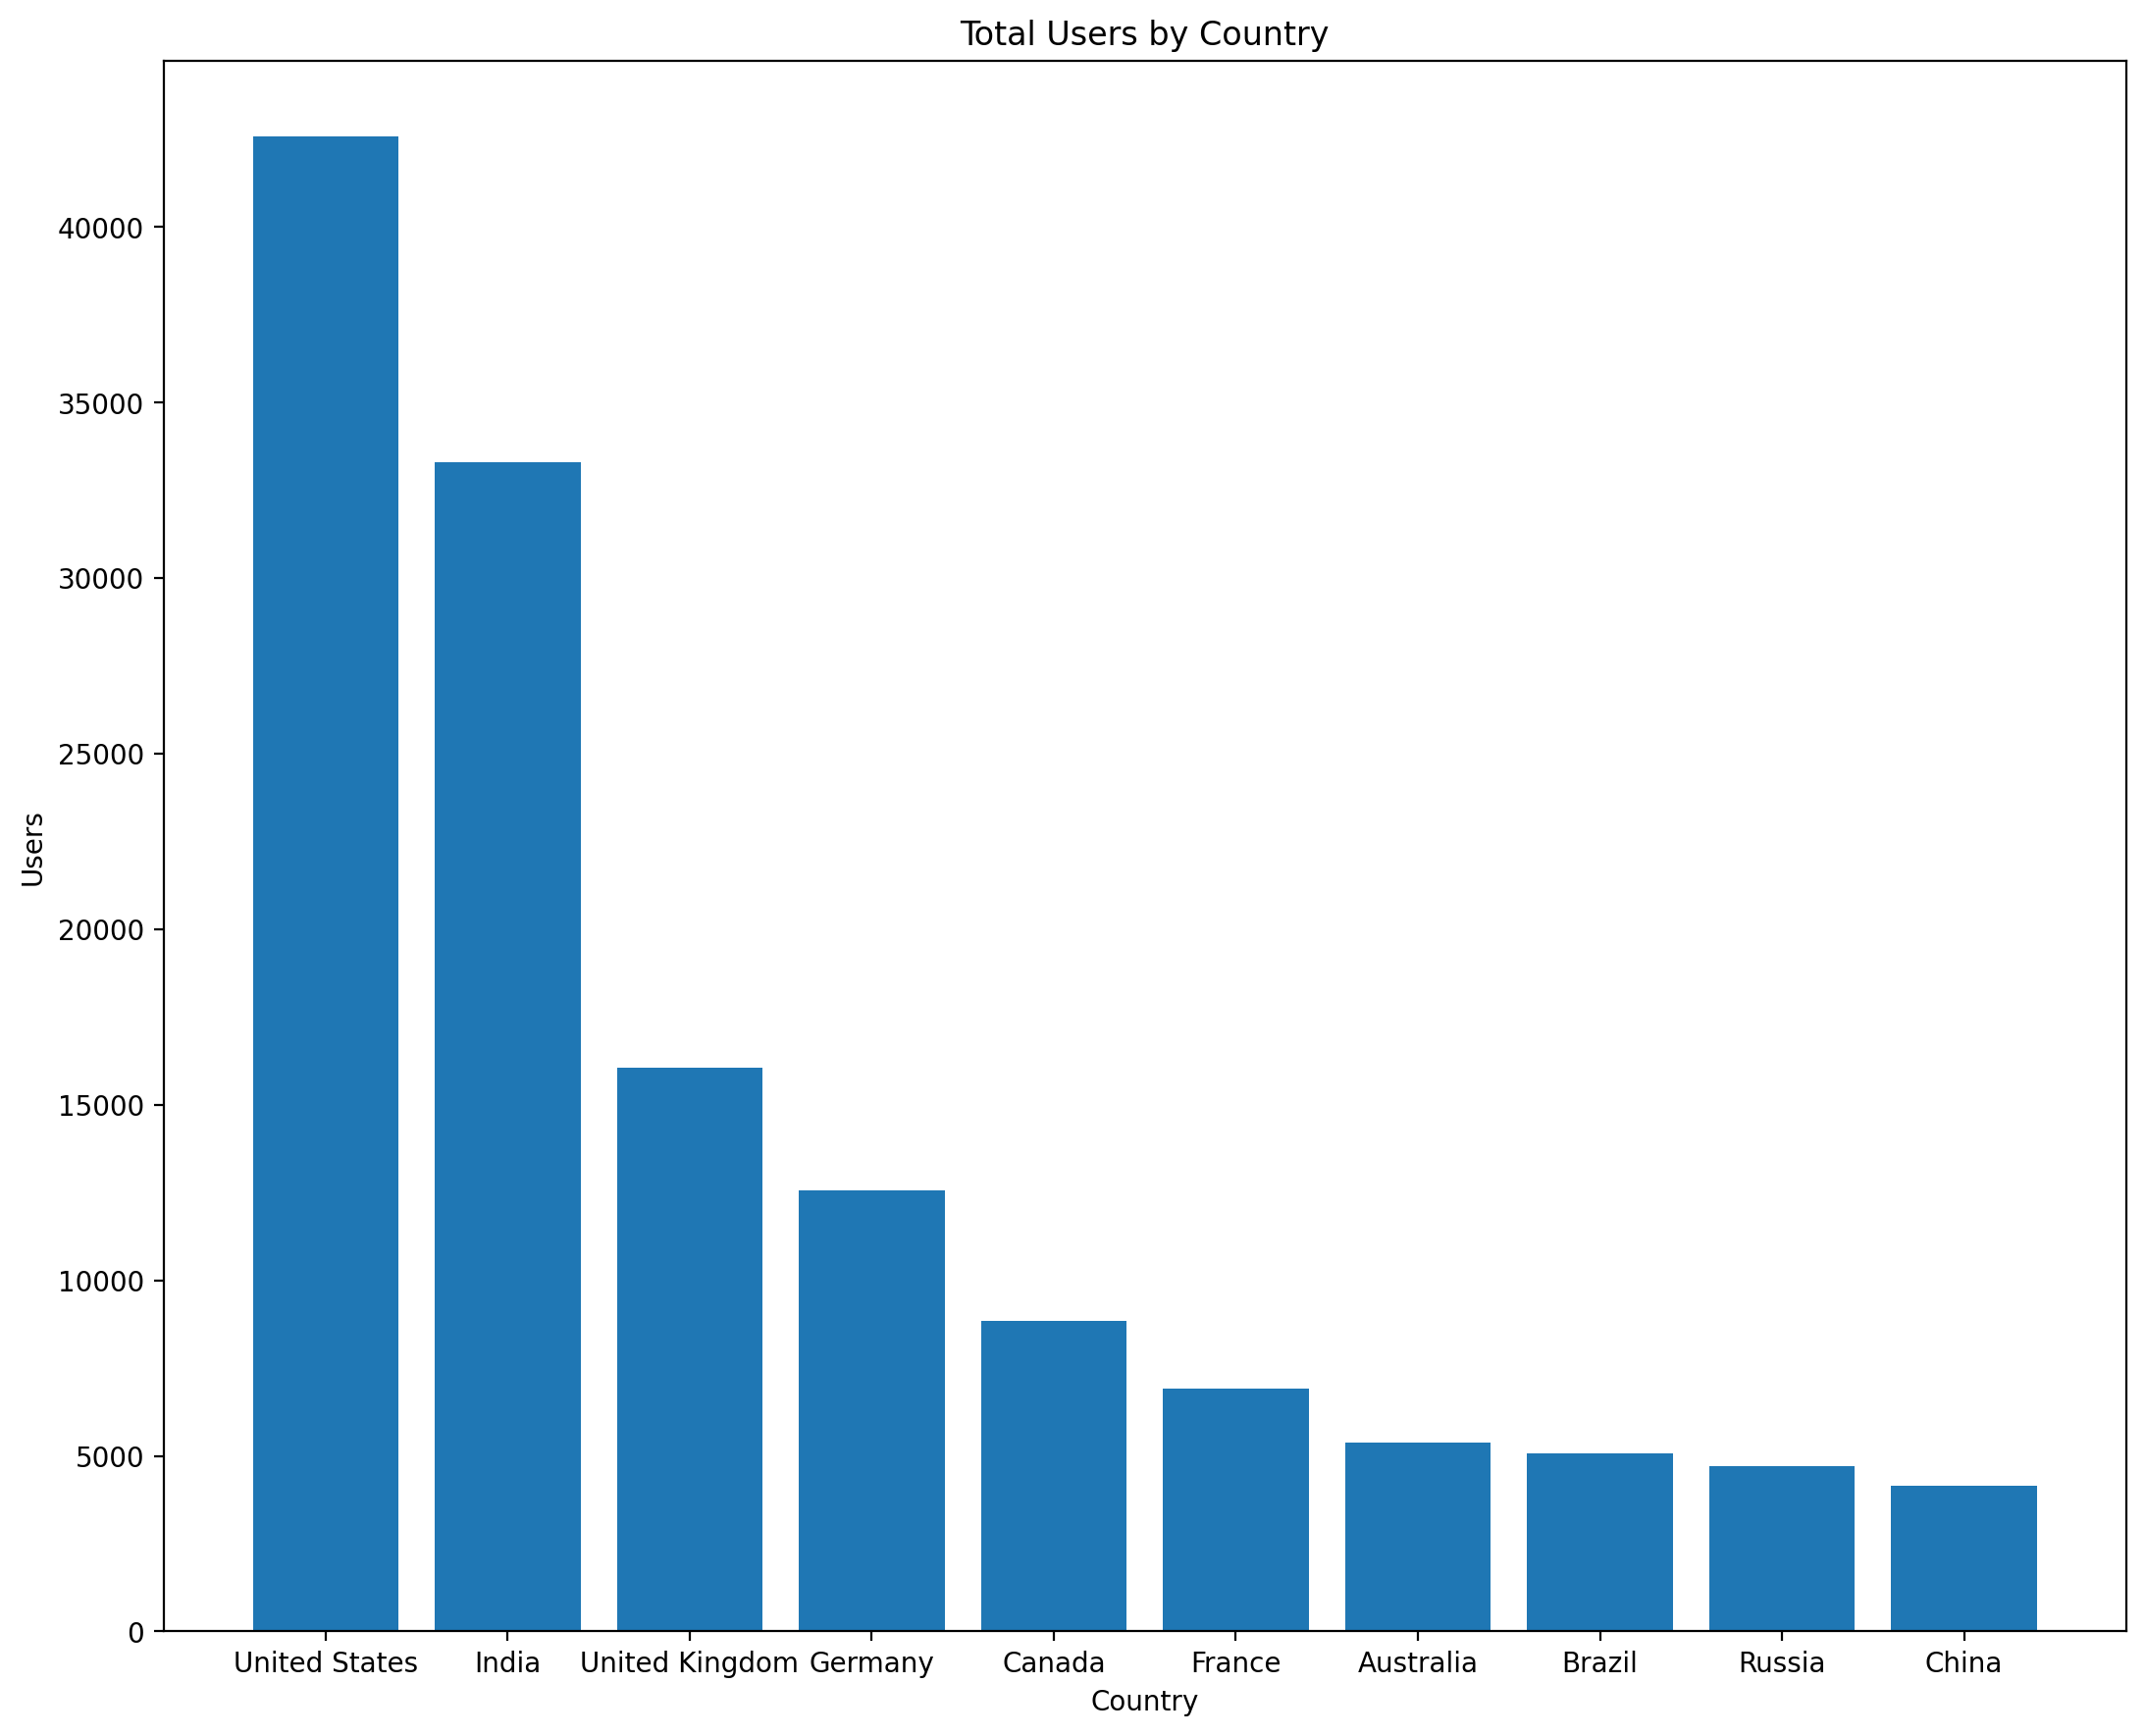

In [70]:
country_data = []
for key in country_count:
    country_data.append([key, country_count[key]])
country_data.sort()
country_data = sorted(country_data, key = lambda x: -x[1])
x = [t[0] for t in country_data[0:10]]
y = [t[1] for t in country_data[0:10]]
print(x, y)
fig = plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
ax.set_xlabel("Country")
ax.set_ylabel("Users")
ax.set_title("Total Users by Country")
plt.savefig('User-country.png', bbox_inches = 'tight')
plt.show()

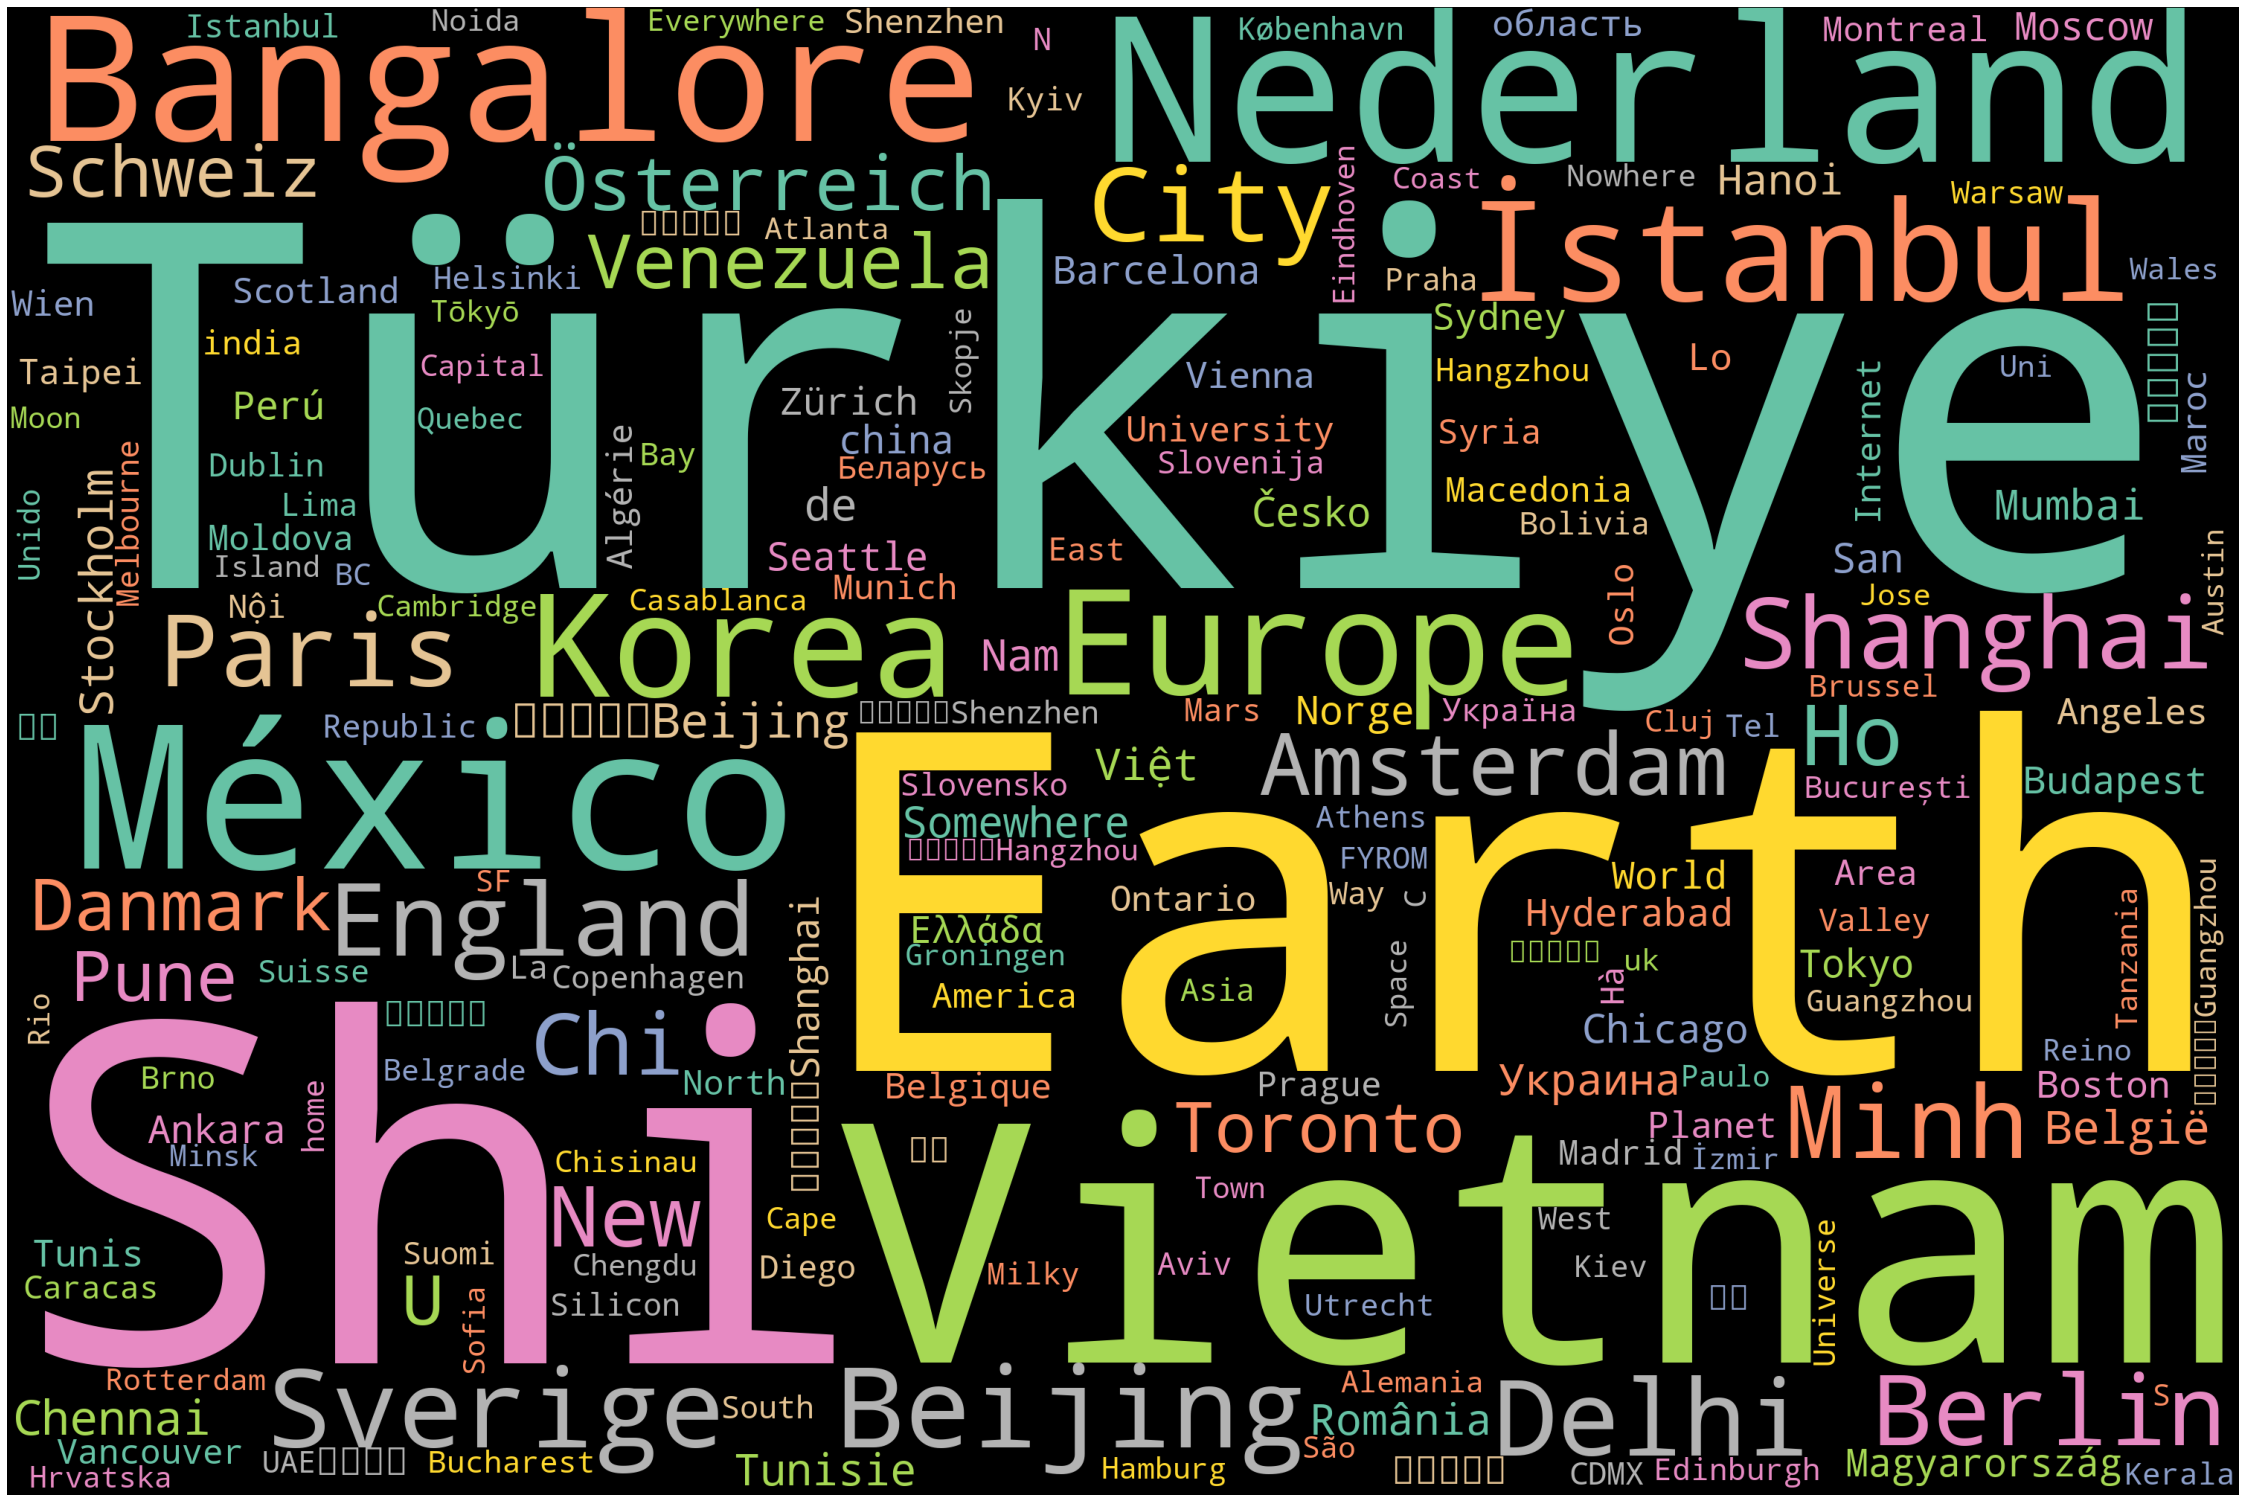

In [167]:
# MISSING PLACES WORDCLOUD
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,
                      background_color='black', colormap='Set2',
                      collocations=False, stopwords = STOPWORDS).generate(random)

plot_cloud(wordcloud)

In [40]:
## Get reputation per country
country_rep = {}
for country in user_country:
    if country not in country_rep:
        country_rep[country] = 0
    for user in user_country[country]:
        country_rep[country] += int(user["Reputation"])

['United States', 'United Kingdom', 'Germany', 'India', 'Canada', 'Australia', 'France', 'Netherlands', 'Sweden', 'Switzerland'] [191651386, 59428698, 36002357, 28551091, 21535592, 17653611, 15501128, 11854039, 8528428, 8447955]


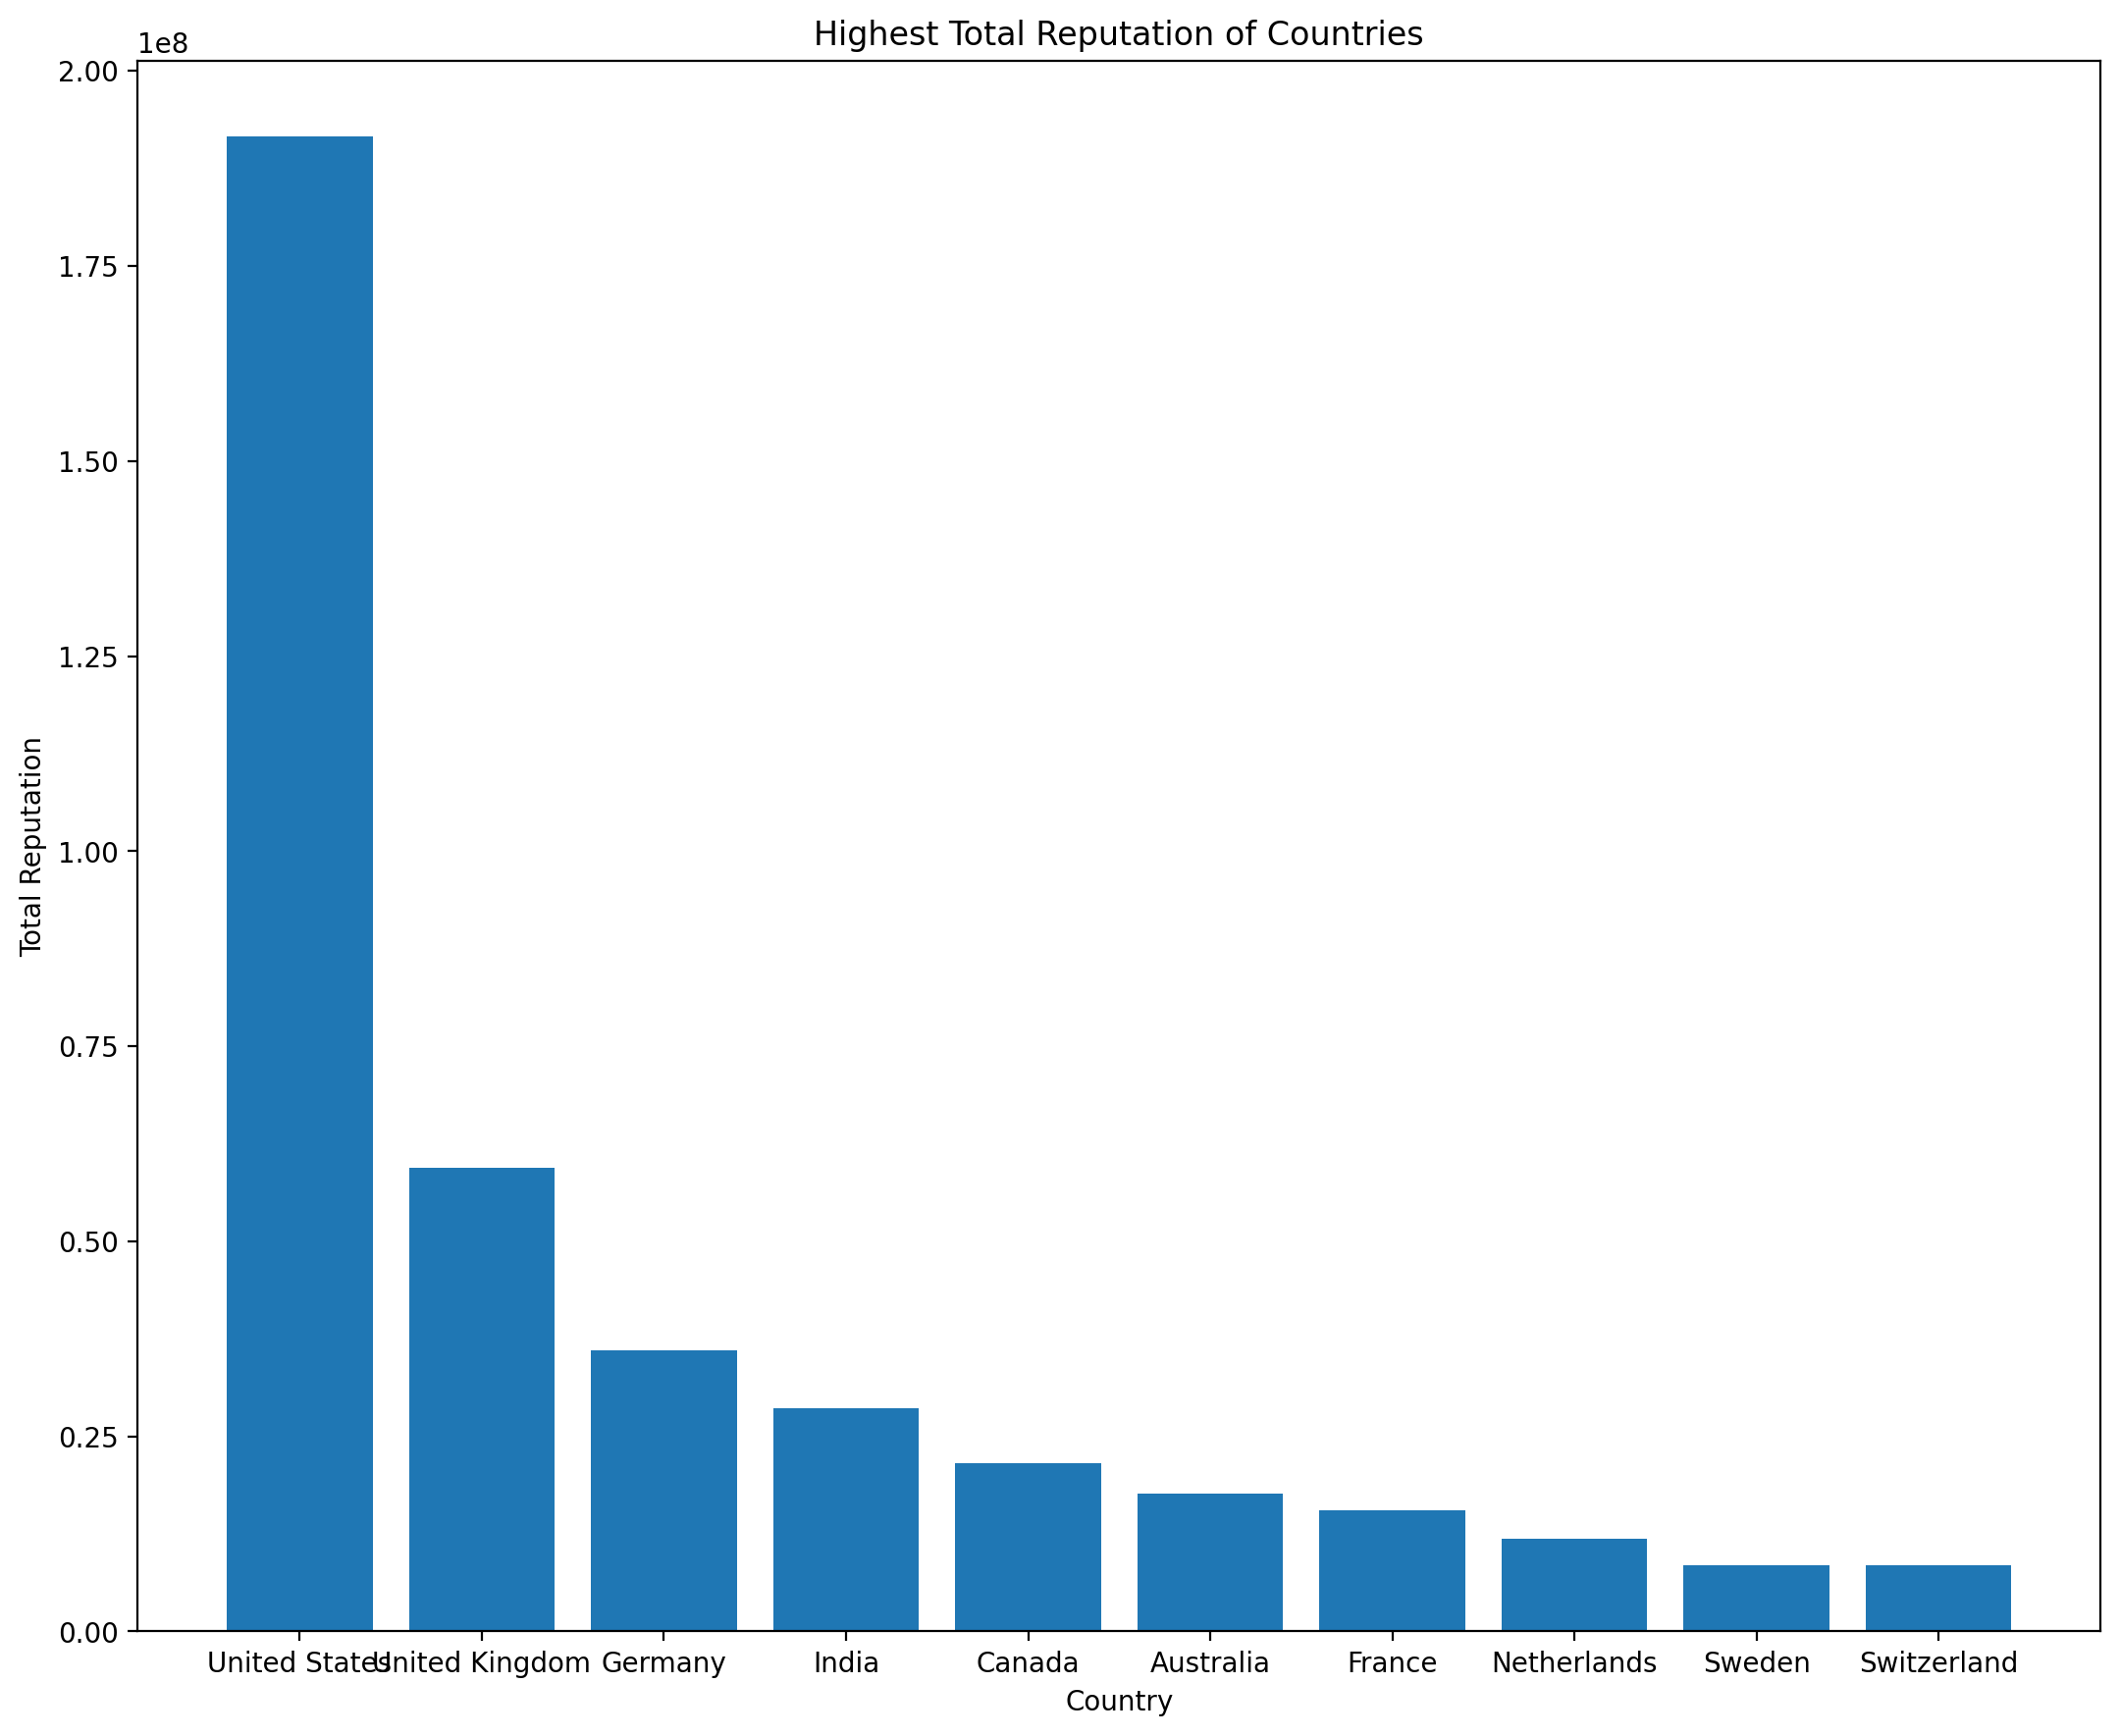

In [43]:
## TOTAL REPO
country_data = []
for key in country_rep:
    country_data.append([key, country_rep[key]])

country_data.sort()
country_data = sorted(country_data, key = lambda x: -x[1])
x = [t[0] for t in country_data[0:10]]
y = [t[1] for t in country_data[0:10]]
print(x, y)
fig = plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
ax.set_xlabel("Country")
ax.set_ylabel("Total Reputation")
ax.set_title("Highest Total Reputation of Countries")
plt.savefig('Country-Total-Rep.png', bbox_inches = 'tight')
plt.show()

['Switzerland', 'Austria', 'New Zealand', 'Sweden', 'United Kingdom', 'Finland', 'Norway', 'Australia', 'Netherlands', 'Denmark'] [4488.817747077577, 3989.75665748393, 3860.6507806080526, 3785.36529072348, 3705.2620487561567, 3512.898305084746, 3316.1356088560888, 3273.4305581309104, 3148.483134130146, 3022.468267581475]


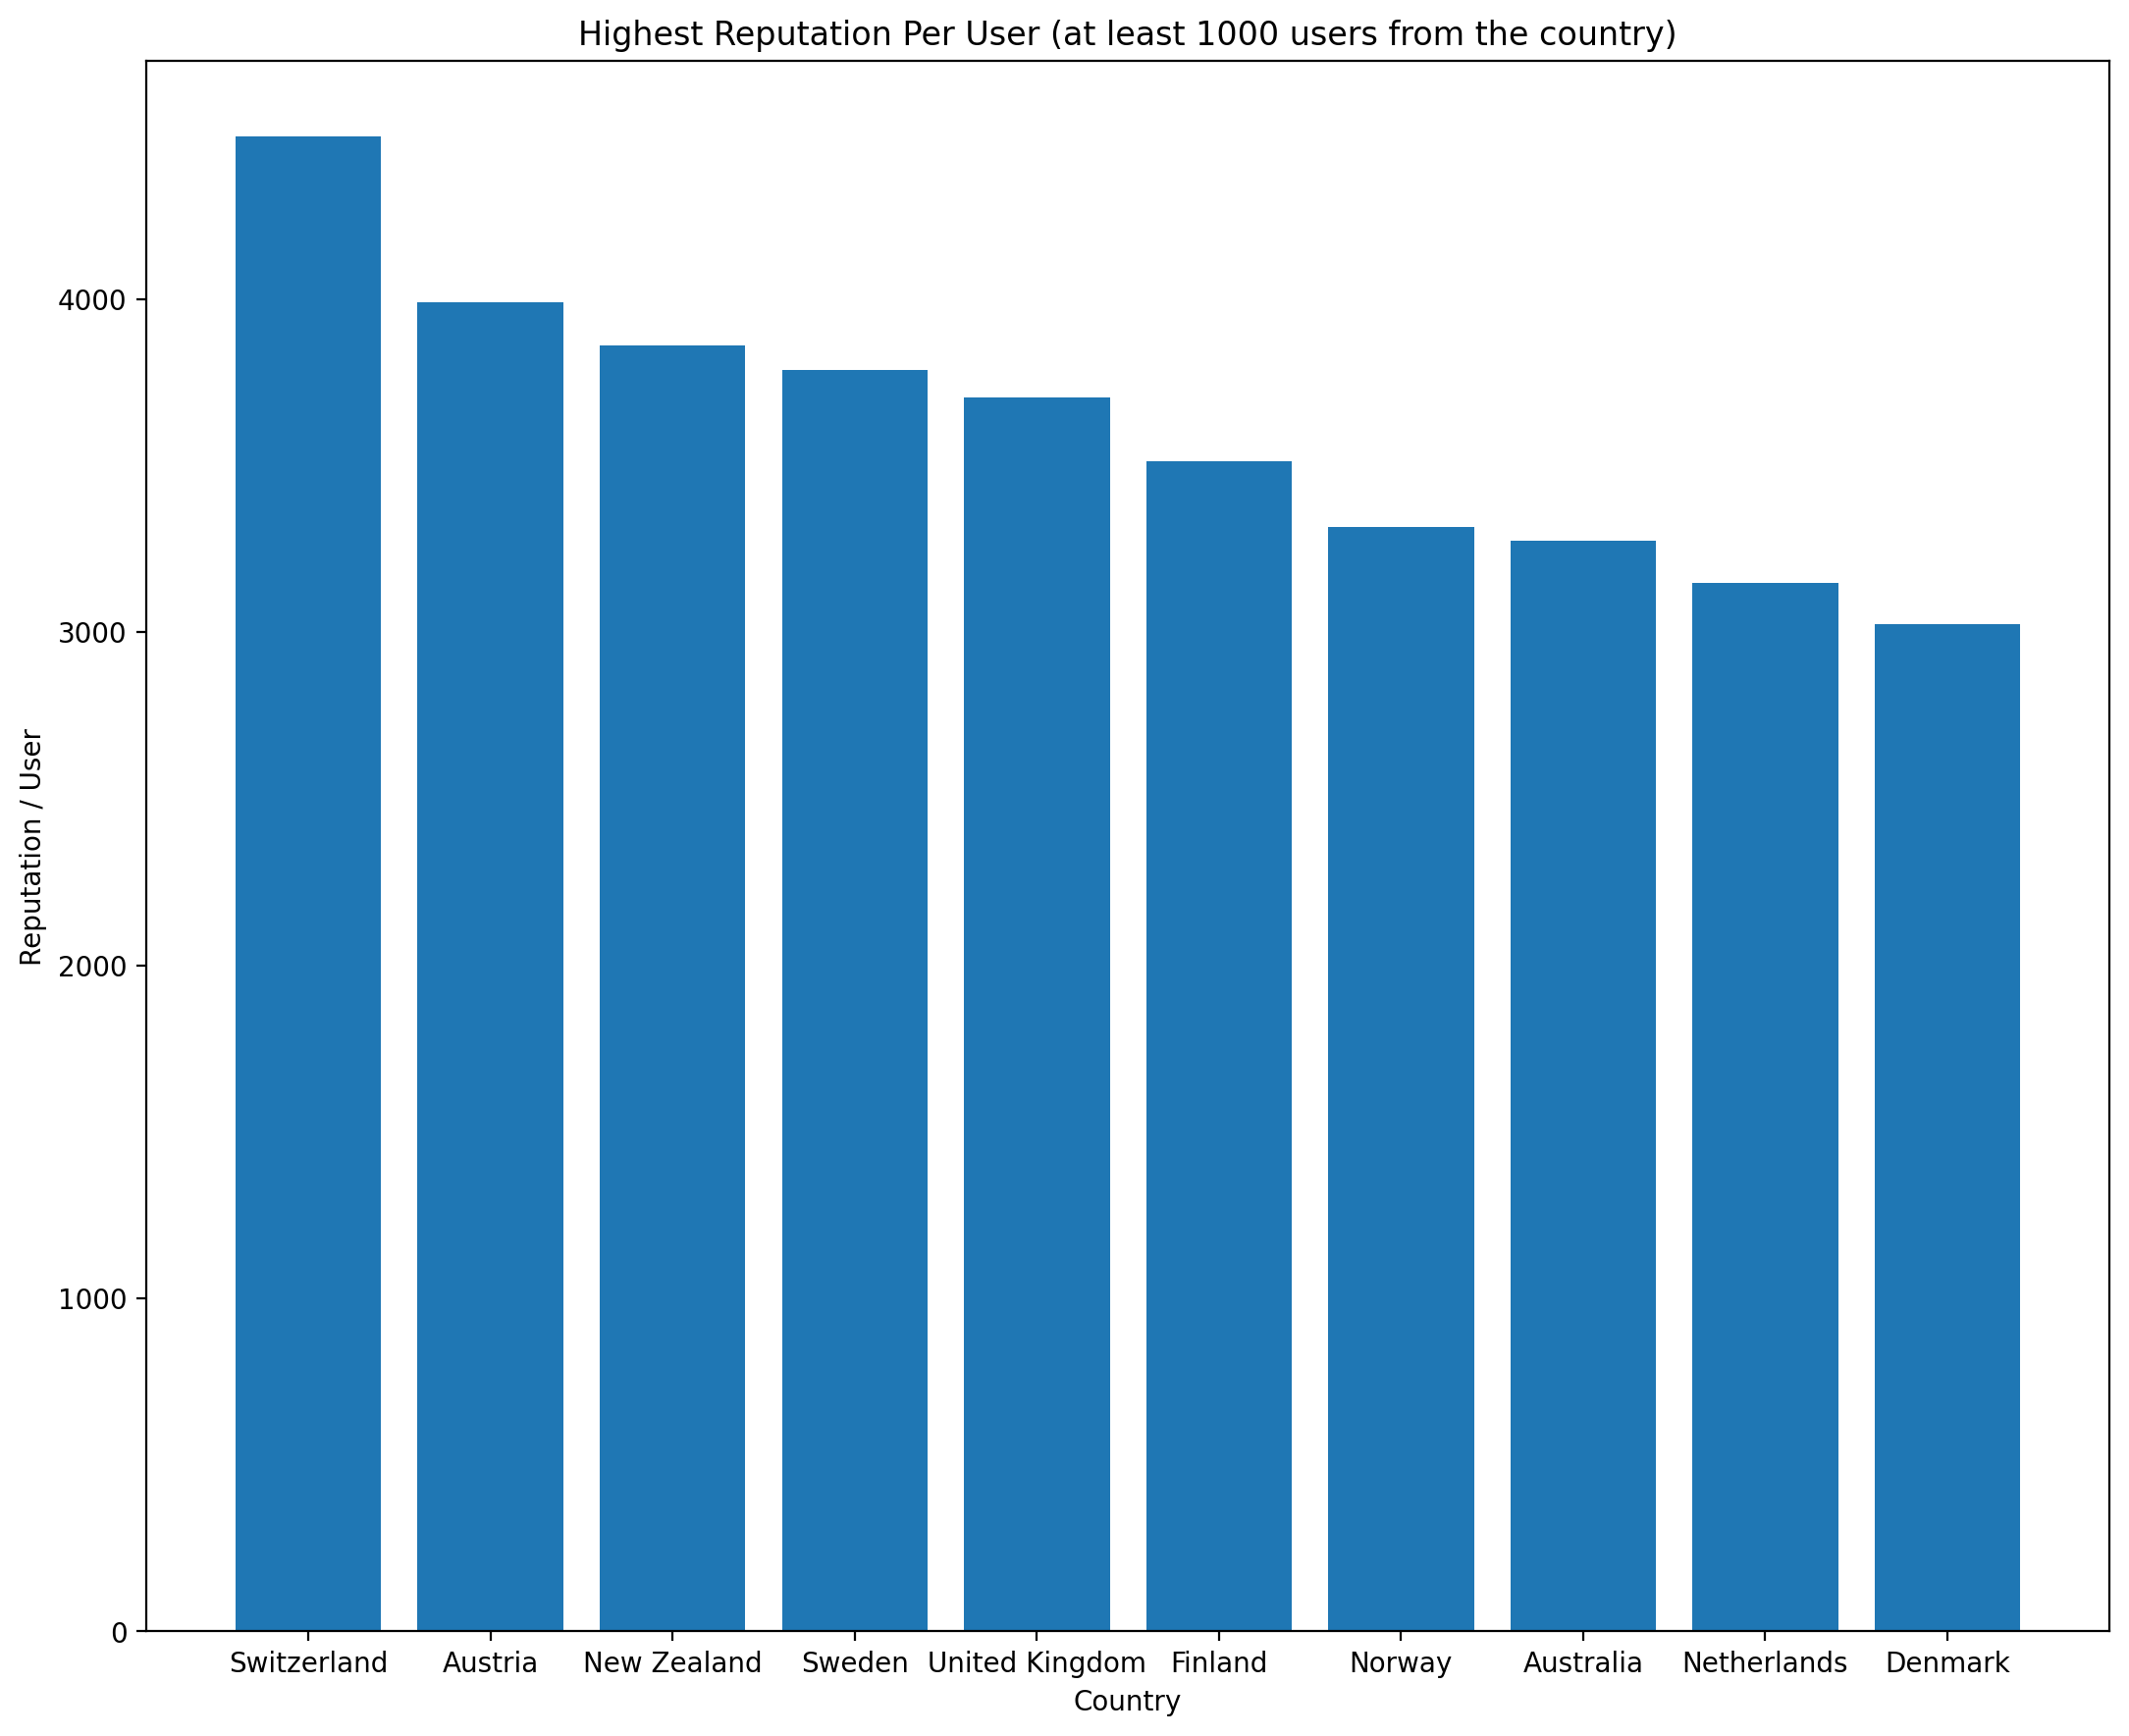

In [45]:
## REPO / USER for user > 1000
country_data = []
for key in country_rep:
    if country_count[key] > 1000:
        country_data.append([key, country_rep[key]/country_count[key]])

country_data.sort()
country_data = sorted(country_data, key = lambda x: -x[1])
x = [t[0] for t in country_data[0:10]]
y = [t[1] for t in country_data[0:10]]
print(x, y)
fig = plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
ax.set_title("Highest Reputation Per User (at least 1000 users from the country)")
ax.set_xlabel("Country")
ax.set_ylabel("Reputation / User")
plt.savefig('Most-helpful.png', bbox_inches = 'tight')
plt.show()

['Indonesia', 'South Korea', 'Iran', 'China', 'India', 'Pakistan', 'Brazil', 'Turkey', 'Philippines', 'Bangladesh'] [547.6097352690009, 586.4369863013699, 614.9902363823227, 852.512506012506, 856.9783587465482, 877.016094875053, 925.8804215646534, 992.3931133428981, 1064.9732673267326, 1120.632420091324]


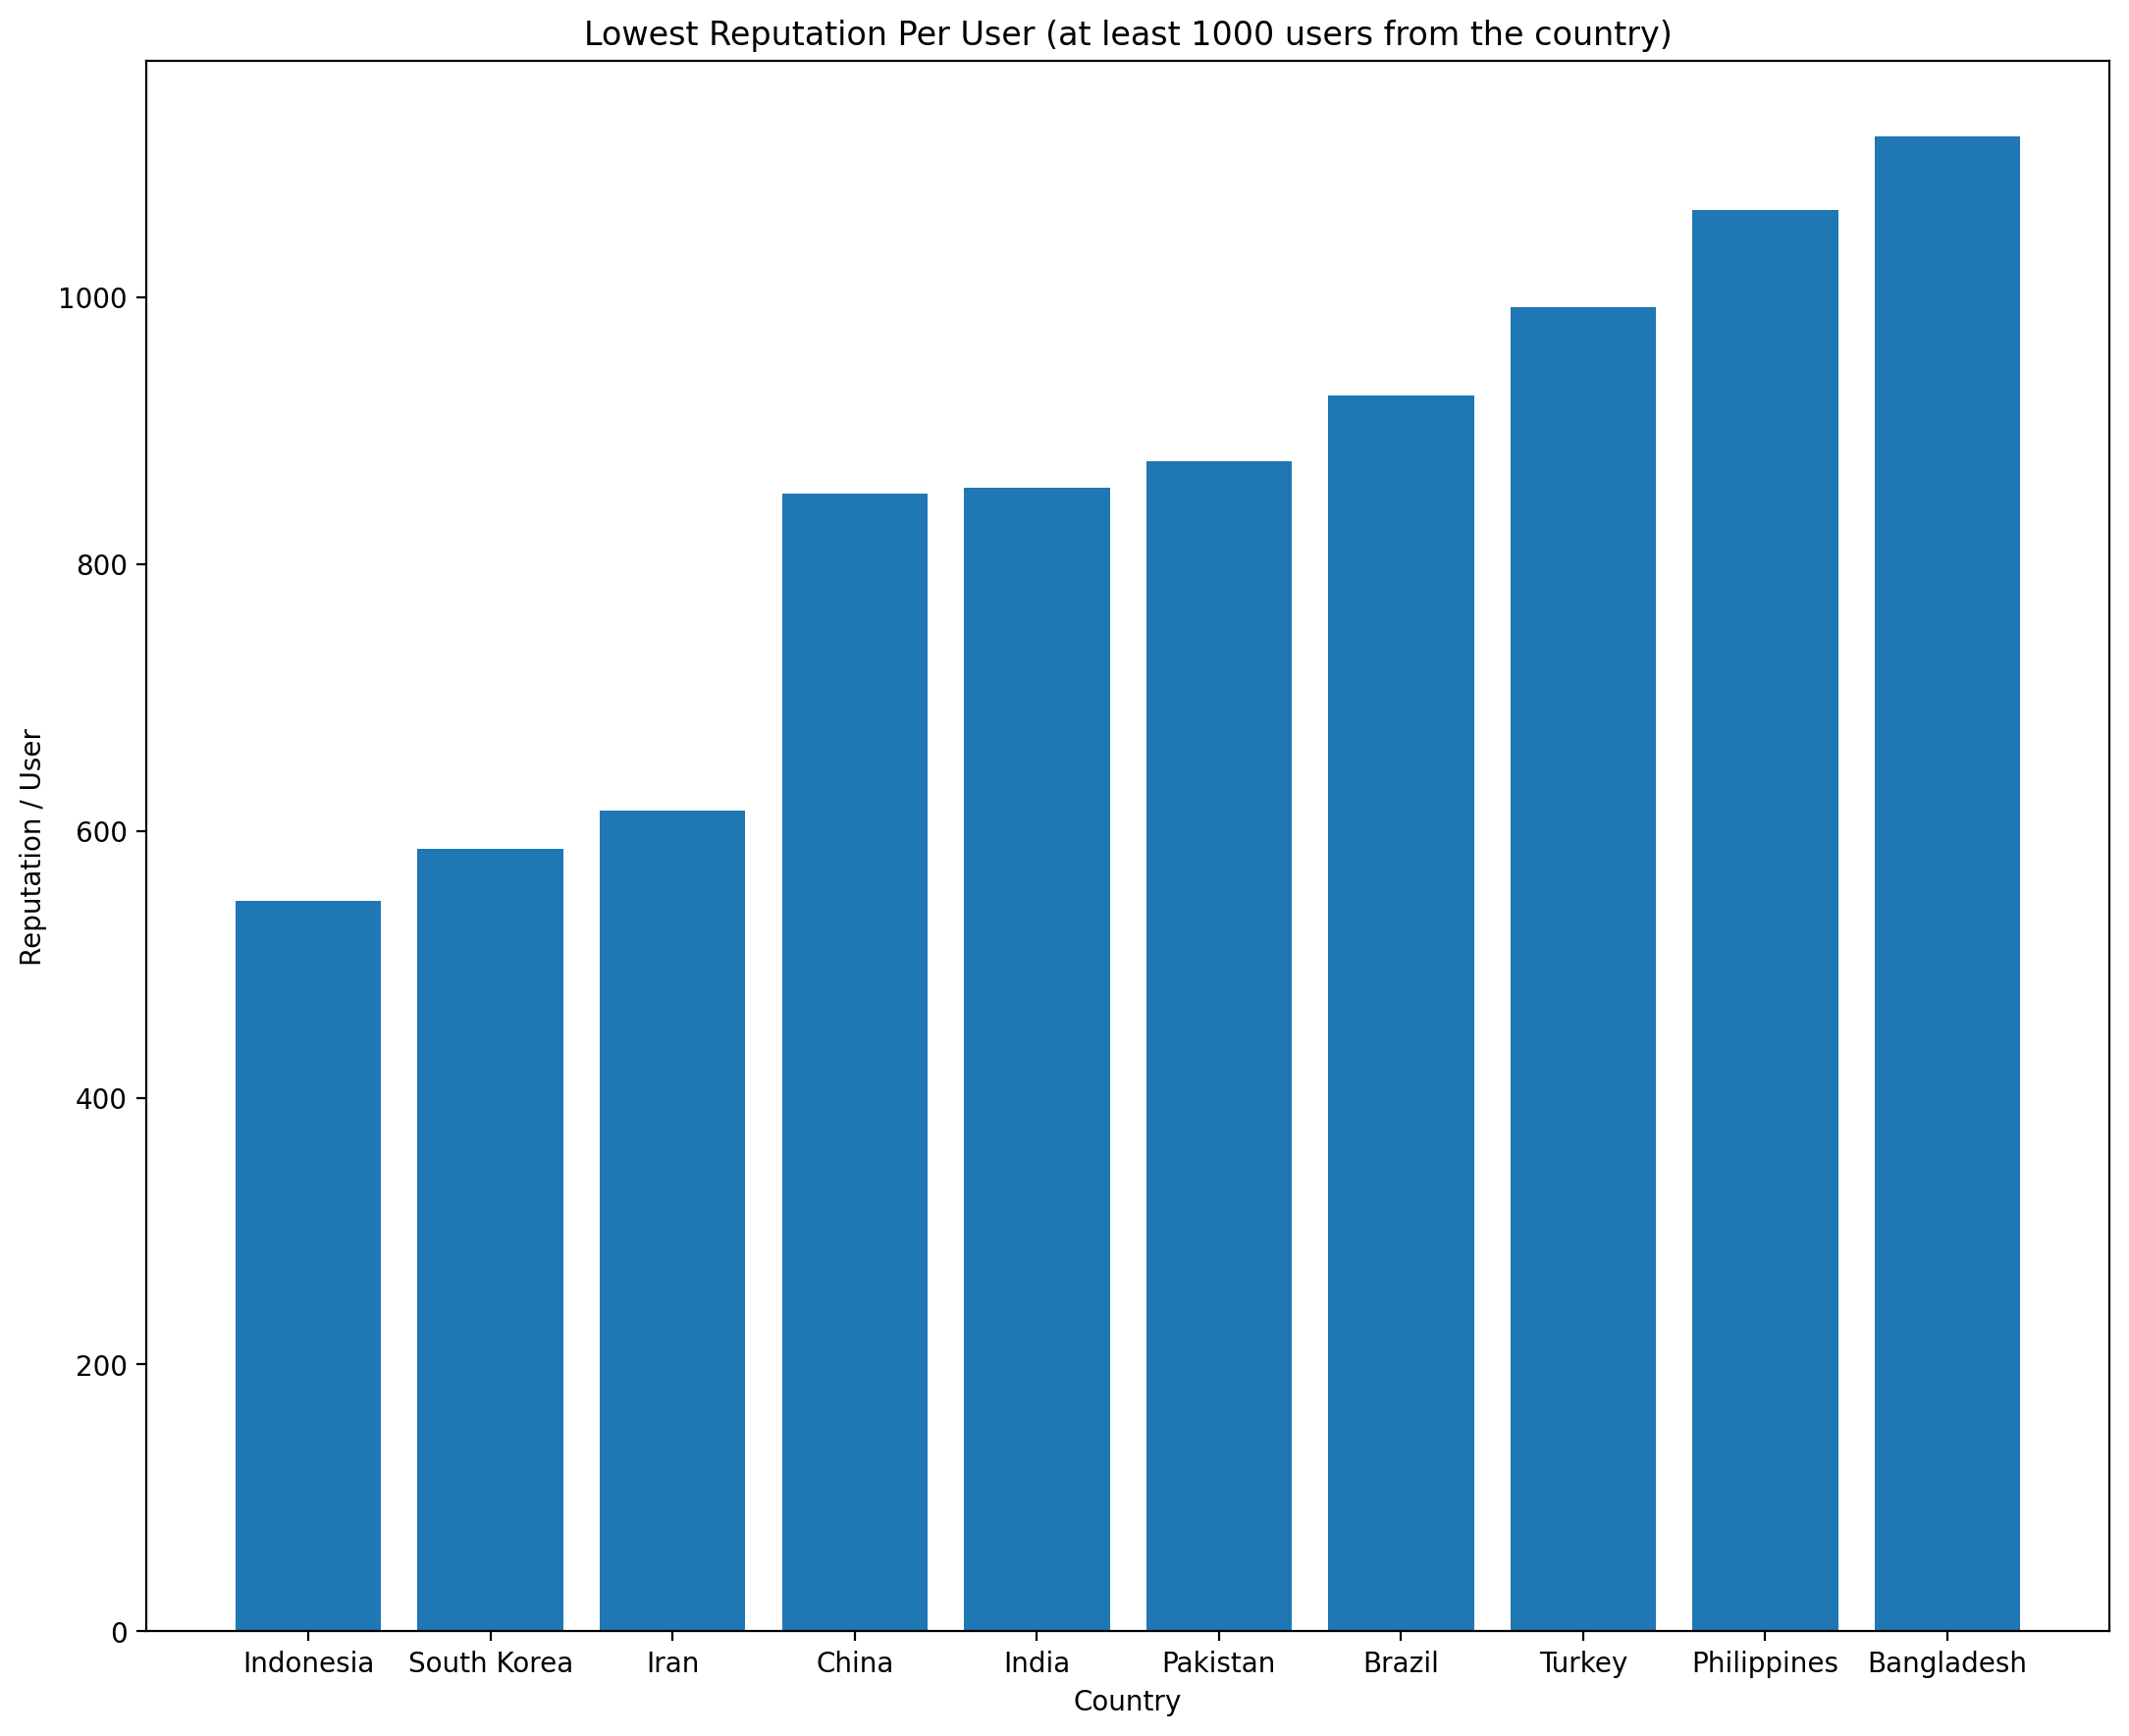

In [46]:
## LOWEST REPO / USER for user > 1000
country_data = []
for key in country_rep:
    if country_count[key] > 1000:
        country_data.append([key, country_rep[key]/country_count[key]])
        
country_data.sort()
country_data = sorted(country_data, key = lambda x: x[1])
x = [t[0] for t in country_data[0:10]]
y = [t[1] for t in country_data[0:10]]
print(x, y)
fig = plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
ax.set_title("Lowest Reputation Per User (at least 1000 users from the country)")
ax.set_xlabel("Country")
ax.set_ylabel("Reputation / User")
plt.savefig('Least-Helpful.png', bbox_inches = 'tight')
plt.show()

In [47]:
### GEO DATA OR WHAT
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

In [48]:
code_list = alpha3code(user_country)

In [50]:
import json
shapefile = 'country_data/ne_110m_admin_0_countries.shp'
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()
print(gdf[gdf['country'] == 'Antarctica'])#Drop row corresponding to 'Antarctica'
gdf = gdf.drop(gdf.index[159])
cc = {}
cc["code"] = []
cc["count"] = []
for country in country_count:
    try:
        code = pycountry.countries.get(name=country).alpha_3
    except:
        continue
    cc["code"].append(code)
    cc["count"].append(country_count[country])
df = pd.DataFrame(cc)
merged = gdf.merge(df,
                   left_on = 'country_code',
                   right_on = 'code')
merged_json = json.loads(merged.to_json())#Convert to String like object.
json_data = json.dumps(merged_json)

        country country_code  \
159  Antarctica          ATA   

                                              geometry  
159  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...  


In [55]:
!pip install selenium

  Using cached selenium-3.141.0-py2.py3-none-any.whl (904 kB)


In [56]:
from bokeh.io import output_notebook, show, output_file, export_png
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, LogColorMapper, LogTicker
from bokeh.palettes import brewer
geosource = GeoJSONDataSource(geojson = json_data)
palette = brewer['YlGnBu'][8]
palette = palette[::-1]
color_mapper = LogColorMapper(palette = palette, low = 5, high = 50000)
color_bar = ColorBar(color_mapper=color_mapper,
                     label_standoff=8,
                     width = 500,
                     height = 20,
                     border_line_color=None,
                     location = (0,0), 
                     ticker = LogTicker(),
                     orientation = 'horizontal')
#                      major_label_overrides = tick_labels)#Create figure object.
p = figure(title = 'Stack Overflow Users Interacting with Python posts', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.patches('xs','ys', source = geosource,
          fill_color = {'field' :'count',
                        'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
p.add_layout(color_bar, 'below')
output_notebook()
export_png(p, filename="map.png")
show(p)

Loading BokehJS ...

In [60]:
relevant = ["United States", "United Kingdom", "India", "Germany", "Bangladesh", "Mexico", "Brazil"]
mydate = datetime.datetime.strptime("2008-08-01", "%Y-%m-%d")
dates = []
for i in range(135):
    dates.append(mydate)
    next_month = datetime.datetime(mydate.year + (mydate.month // 12), ((mydate.month % 12) + 1), 1)
    mydate = next_month

country_date = {}

for date in dates:
    country_date[date] = {}
    for country in relevant:
        country_date[date][country] = 0
        for user in user_country[country]:
            u_date = datetime.datetime.strptime(user["CreationDate"][0:10], "%Y-%m-%d")
            if u_date < date:
                country_date[date][country] += 1
            else:
                break
        if country_date[date][country] == 0:
            del country_date[date][country]
            
# pprint.pprint(country_date)
ys = [[] for i in range(len(relevant))]
c_ind = 0
for c in relevant:
    for date in dates:
        if not c in country_date[date]:
            ys[c_ind].append(0)
        else:
            ys[c_ind].append(country_date[date][c])
    c_ind += 1
# print(ys)



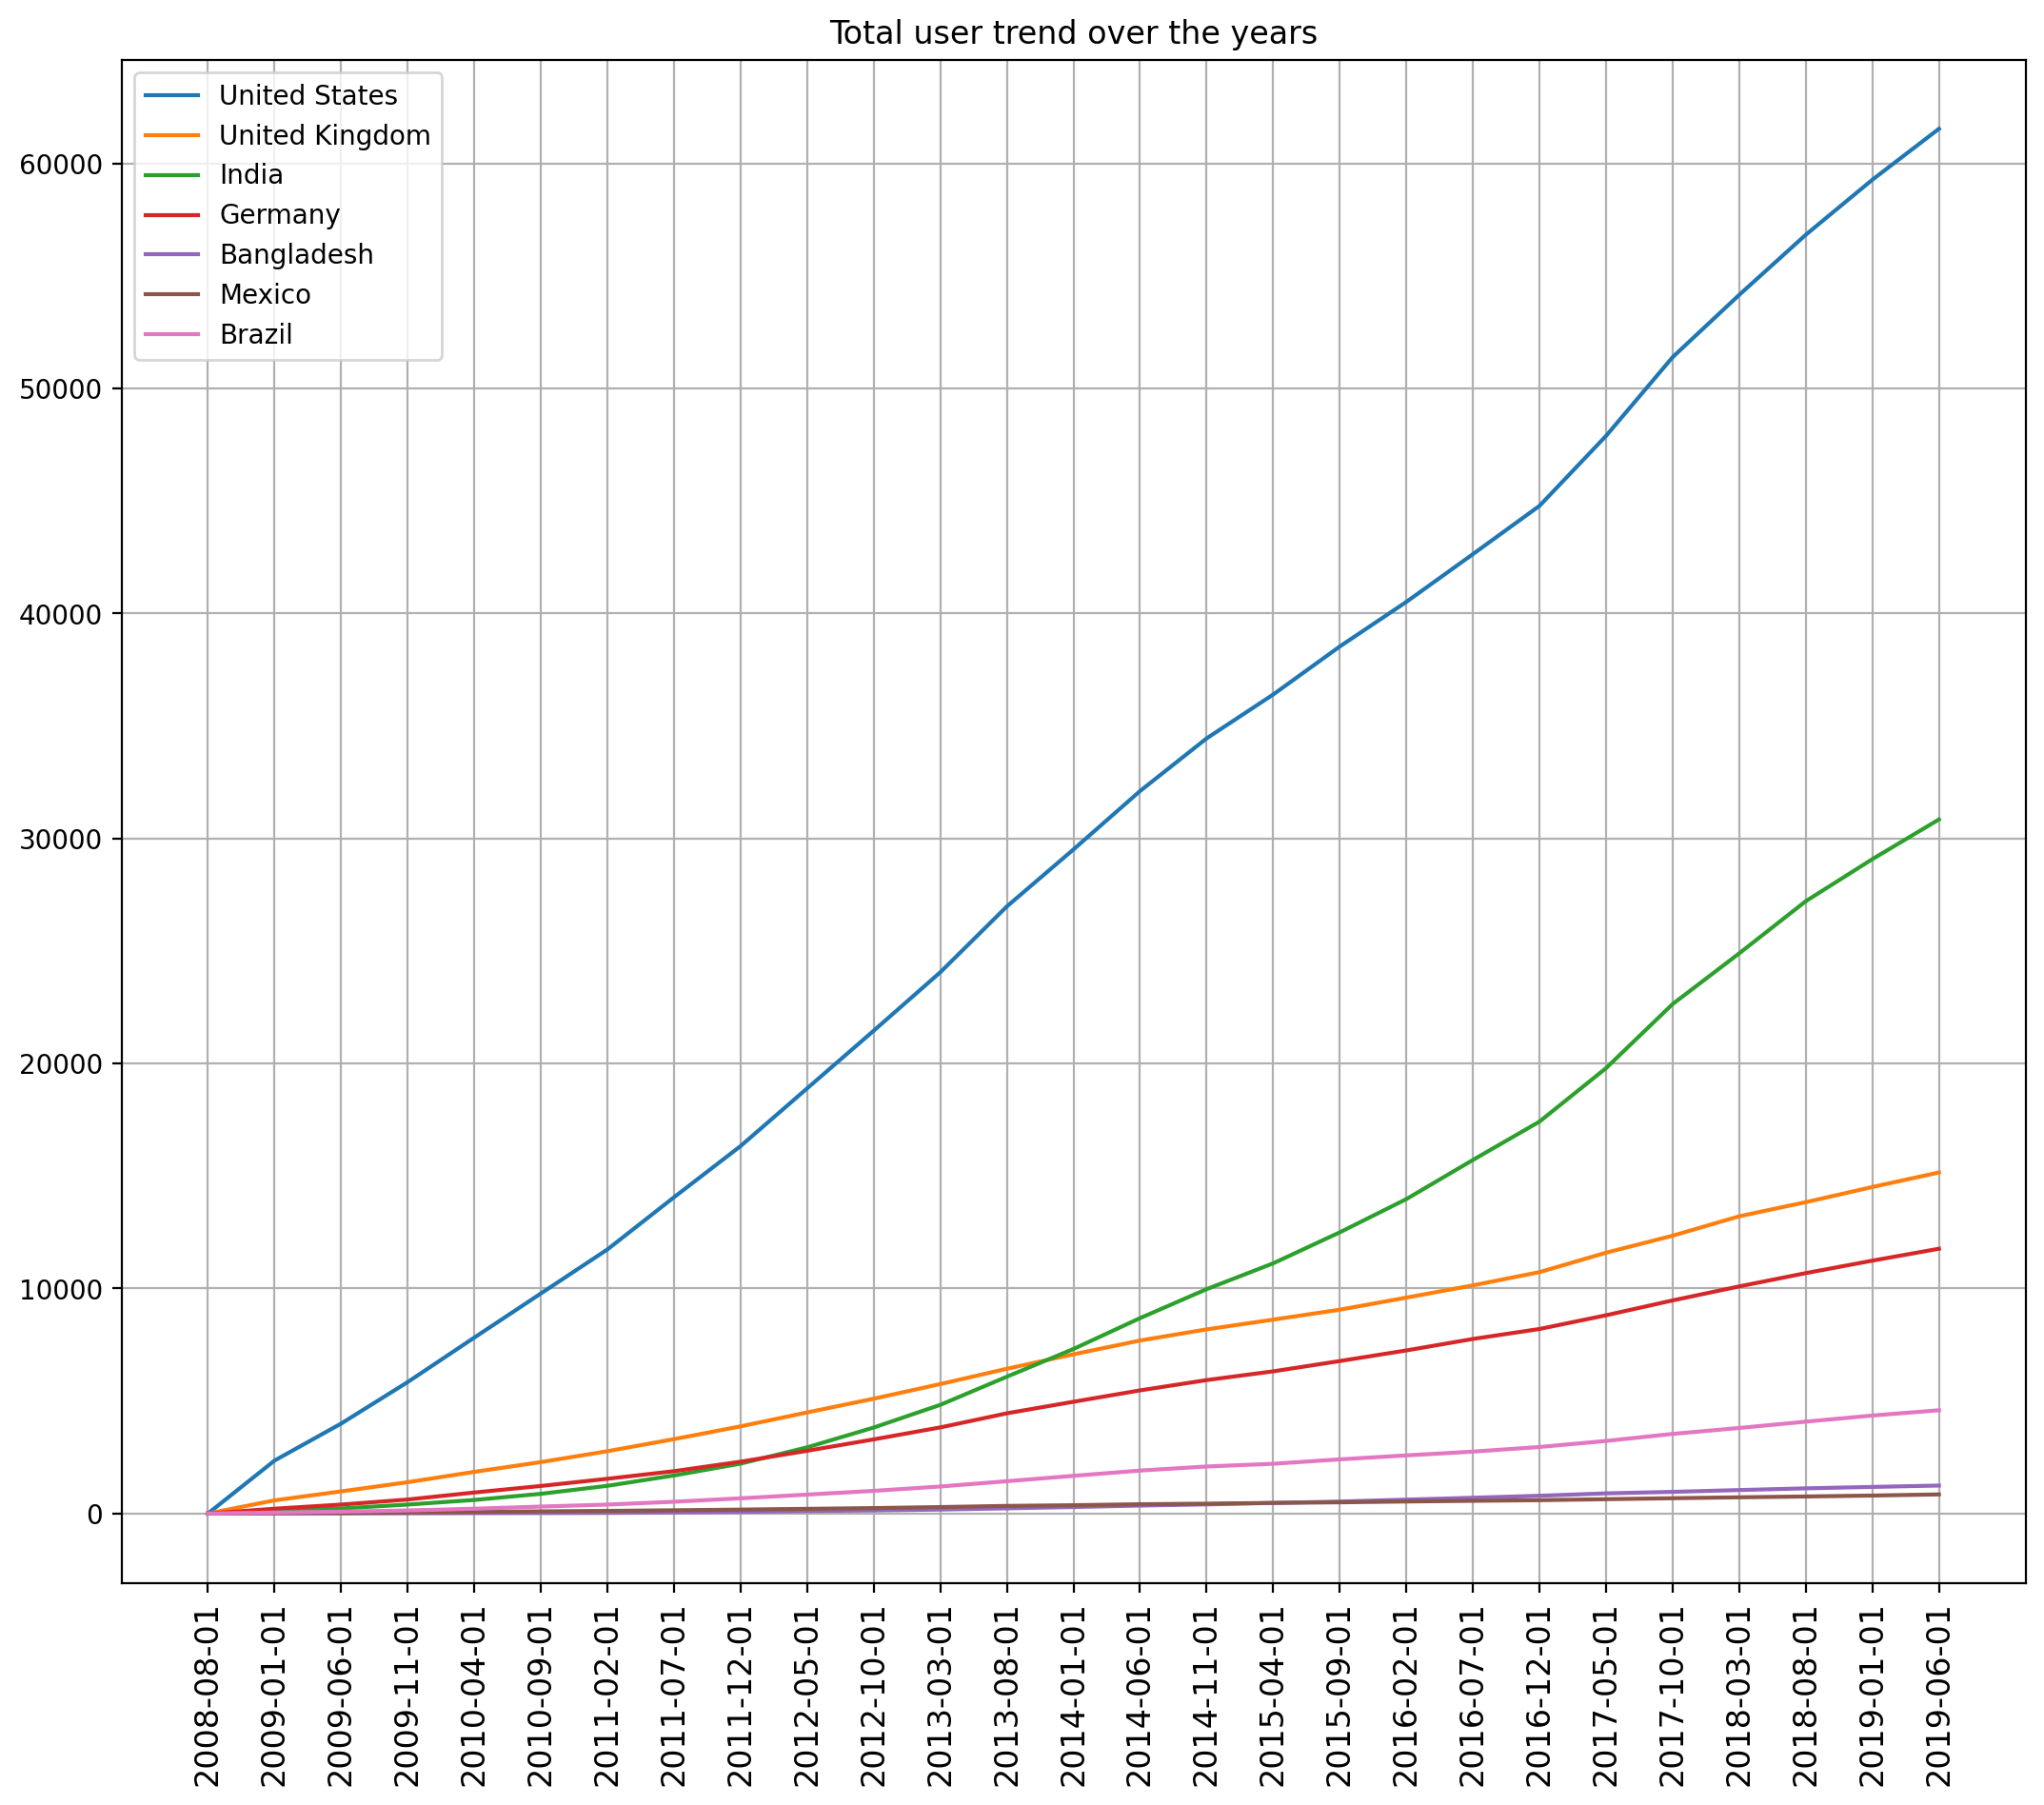

In [61]:
skip_label = 5
x = np.arange(0, len(dates), skip_label)
x_ticks_labels = [str(dates[i])[0:10] for i in x]
fig = plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
for y in ys:
    ax.plot(x, [y[i] for i in x])
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=12)
ax.set_title("Total user trend over the years")
ax.legend(relevant)
plt.grid()
plt.show()

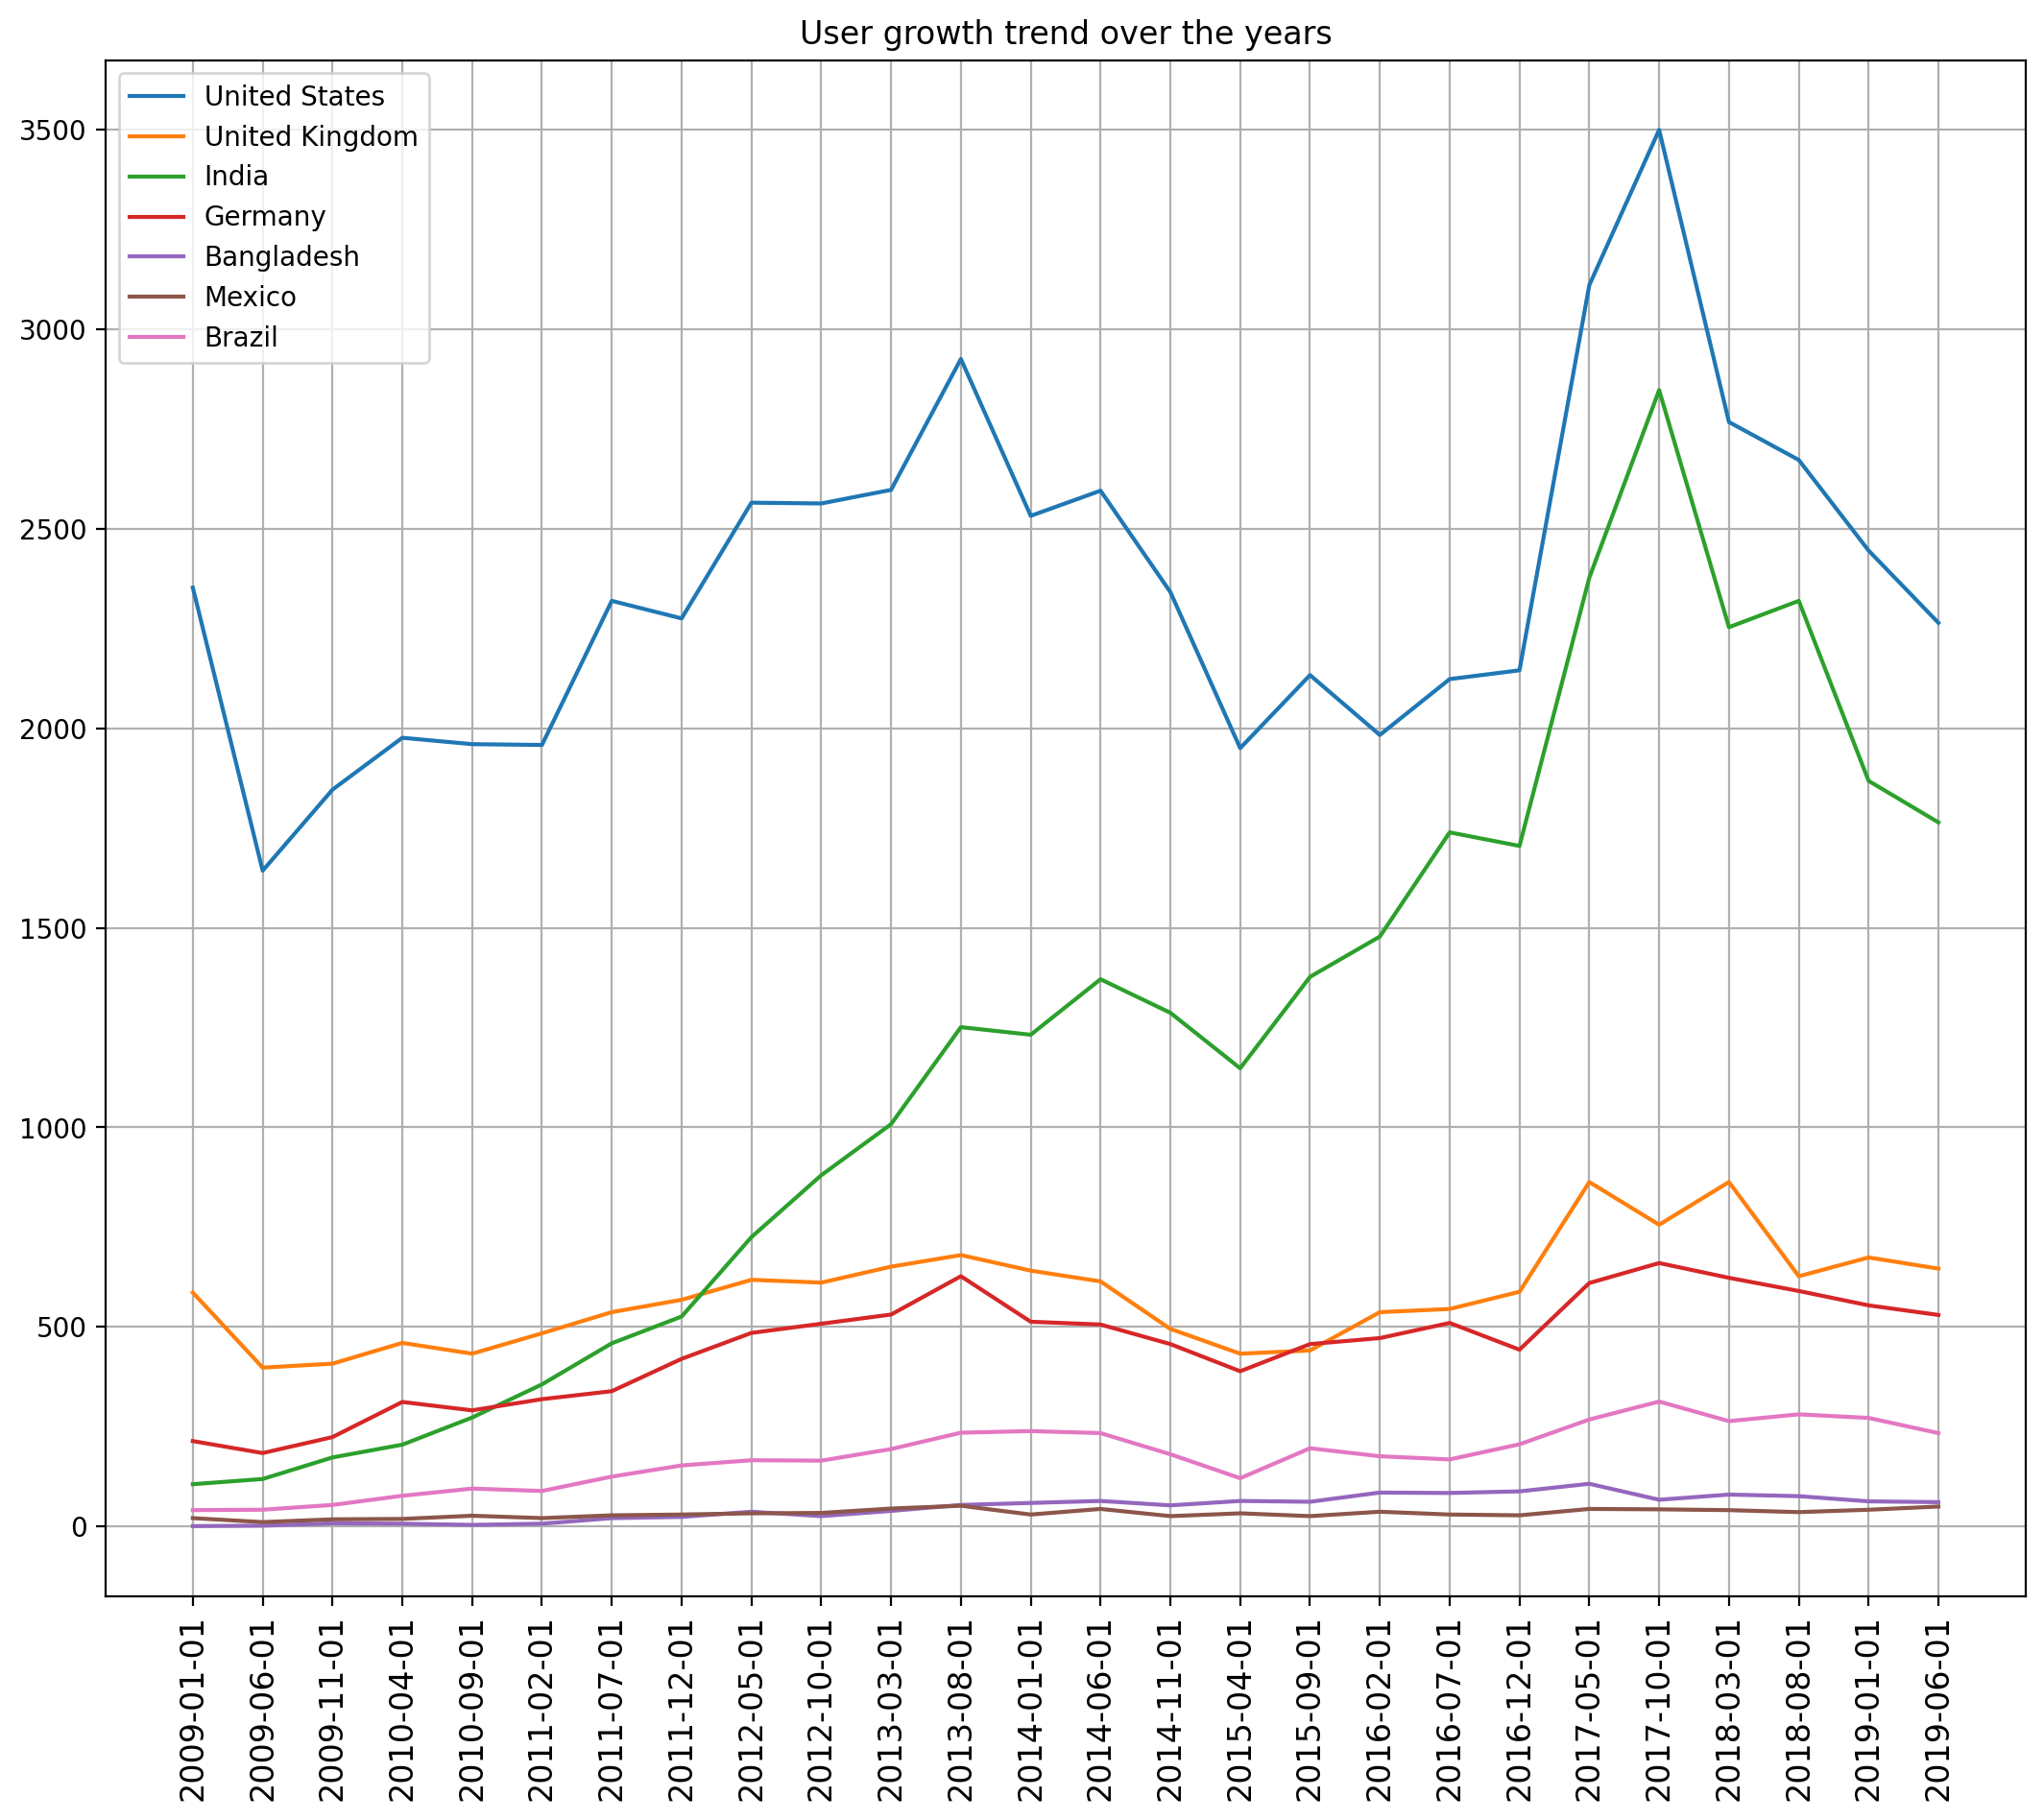

In [72]:
skip_label = 5
x = np.arange(skip_label, len(dates), skip_label)
x_ticks_labels = [str(dates[i])[0:10] for i in x]
fig = plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
for y in ys:
    ax.plot(x, [y[i] - y[i - skip_label] for i in x])
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=12)
ax.set_title("User growth trend over the years")
ax.legend(relevant)
plt.savefig("User-Growth.png", bbox_inches = 'tight')
plt.grid()
plt.show()

In [122]:
posts = db["Posts"]
pprint.pprint(posts.find_one())

{'AcceptedAnswerId': '342',
 'AnswerCount': '12',
 'Body': '<p>I am about to build a piece of a project that will need to '
         "construct and post an XML document to a web service and I'd like to "
         'do it in Python, as a means to expand my skills in it.  </p>\n'
         '\n'
         '<p>Unfortunately, whilst I know the XML model fairly well in .NET, '
         "I'm uncertain what the pros and cons are of the XML models in "
         'Python.  </p>\n'
         '\n'
         '<p>Anyone have experience doing XML processing in Python? Where '
         "would you suggest I start? The XML files I'll be building will be "
         'fairly simple.</p>\n',
 'ClosedDate': '2016-03-26T01:51:47.153',
 'CommentCount': '2',
 'CreationDate': '2008-08-02T03:35:55.697',
 'FavoriteCount': '7',
 'Id': '337',
 'LastActivityDate': '2019-05-22T00:27:38.800',
 'LastEditDate': '2016-12-30T12:56:21.493',
 'LastEditorUserId': '2336654',
 'OwnerUserId': '111',
 'PostTypeId': '1',
 'Score': '71',

In [131]:
mydate = datetime.datetime.strptime("2008-08-01", "%Y-%m-%d")
dates = []
for i in range(133):
    dates.append(mydate)
    next_month = datetime.datetime(mydate.year + (mydate.month // 12), ((mydate.month % 12) + 1), 1)
    mydate = next_month

country_date = {}

i = 0
y = []
count = 0
for post in posts.find({},{"CreationDate"}).limit(3000000):
    u_date = datetime.datetime.strptime(post["CreationDate"][0:10], "%Y-%m-%d")
    if u_date > dates[i]:
        y.append(count)
        count = 0
        i += 1
    else:
        count += 1
while len(y) != len(dates):
    y.append(0)
print(y)

[0, 633, 2980, 2355, 2076, 2013, 2755, 2789, 3410, 3098, 4165, 4351, 4592, 4476, 4540, 5447, 6232, 6034, 7361, 6454, 7172, 6131, 6580, 7216, 8384, 8394, 7143, 8691, 8804, 7992, 9659, 9513, 11825, 10358, 11082, 10534, 11202, 11864, 10375, 10924, 11509, 10503, 13202, 13468, 14775, 14460, 14882, 15024, 16855, 16449, 15054, 17369, 17622, 15904, 18541, 18367, 20476, 21480, 20902, 20715, 23352, 21136, 21480, 25282, 25052, 22552, 25927, 25717, 29407, 26625, 22665, 22250, 24920, 22481, 21911, 23185, 24747, 22387, 24636, 25314, 28831, 28819, 28874, 29330, 30036, 28167, 27132, 30440, 30515, 28119, 31035, 33108, 34772, 33400, 32137, 31290, 30845, 31547, 29781, 32993, 34338, 31172, 35565, 35310, 40520, 37805, 39706, 37975, 41990, 39757, 37554, 41906, 40564, 34991, 39720, 39285, 42551, 40892, 42022, 39466, 44162, 42538, 40092, 44674, 43031, 38472, 43031, 43318, 51293, 50168, 48041, 44690, 0]


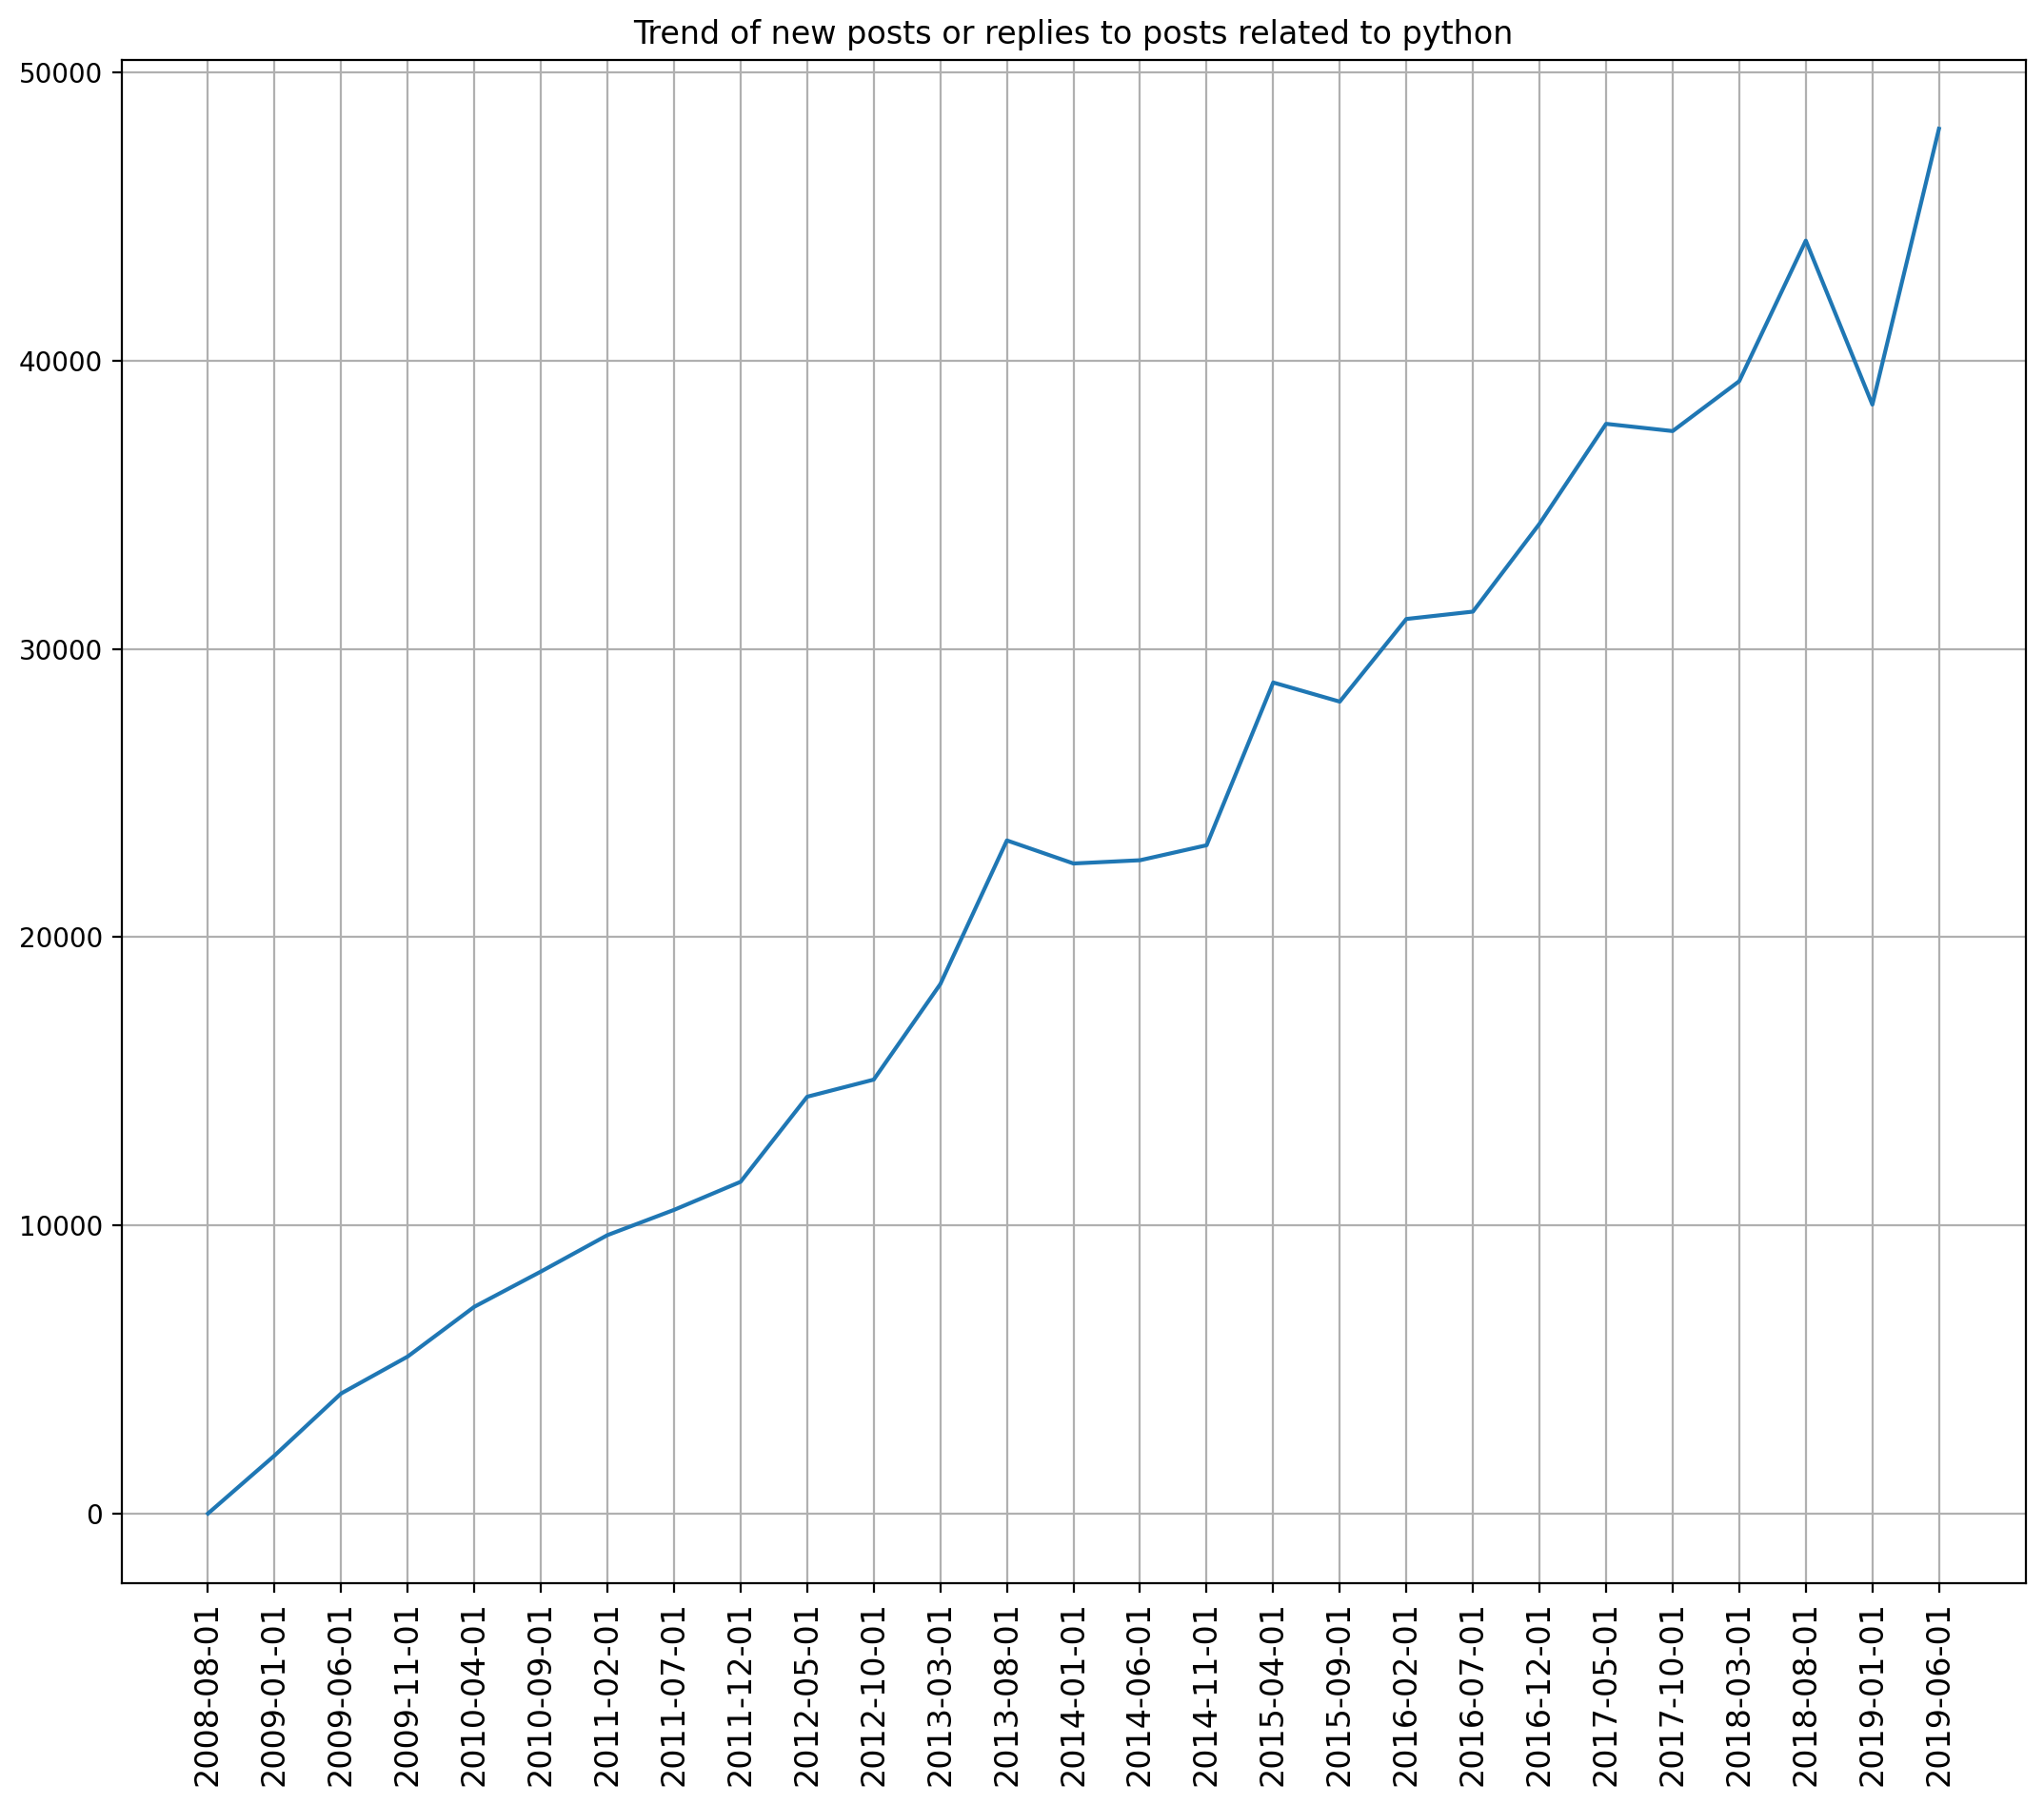

In [132]:
skip_label = 5
x = np.arange(0, len(dates), skip_label)
x_ticks_labels = [str(dates[i])[0:10] for i in x]
fig = plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
ax.plot(x, [y[i] for i in x])
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=12)
ax.set_title("Trend of new posts or replies to posts related to python")
plt.grid()
plt.show()

In [172]:
### AVG POST OPEN TIME
t = datetime.datetime.strptime("2019-09-09", "%Y-%m-%d")
delta = t - t
c = 0
for post in Posts.find({"PostTypeId" : '1', "ClosedDate": { "$exists": "true"}}, {"CreationDate", "ClosedDate"}):
    if "ClosedDate" in post:
        c += 1
        u_date = datetime.datetime.strptime(post["CreationDate"][0:10], "%Y-%m-%d")
        e_date = datetime.datetime.strptime(post["ClosedDate"][0:10], "%Y-%m-%d")
        delta += e_date - u_date
print(delta)


8578955 days, 0:00:00


In [173]:
8578955 / c

101.66686417880379

In [ ]:
## Post is closed after 101 days on average